/home/scarlett/Documents/Summer Intern/OneQ-Optimization/Compact_Graph.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(NetN, NetM))


936 nodes
47 layers
fusion: 4547
begin to validate!
285 286 {727: 20, 710: 26, 934: 34, 737: 48, 687: 59, 936: 65, 692: 103, 830: 105, 504: 131, 593: 139, 609: 140, 506: 148, 508: 165, 854: 171, 505: 179, 510: 180, 616: 210, 613: 214, 617: 228, 550: 203, 401: 13, 908: 28, 52: 31, 488: 47, 353: 57, 741: 67, 501: 83, 595: 107, 382: 178, 384: 193, 784: 199, 799: 228, 699: 51, 36: 72, 658: 108, 841: 24, 359: 38, 272: 71, 542: 126, 537: 152, 462: 175, 739: 15, 121: 1, 887: 95, 365: 79, 281: 87, 295: 88, 453: 137, 377: 162, 330: 59, 321: 201, 391: 31, 311: 20, 61: 221, 63: 115, 763: 184, 758: 0, 393: 28, 389: 14, 839: 22, 171: 70, 748: 82, 265: 114, 178: 150, 317: 152, 434: 220, 325: 248, 433: 250, 103: 255, 781: 200, 415: 95, 443: 96, 905: 27, 89: 50, 421: 78, 789: 105, 429: 122, 197: 177, 195: 192, 804: 242, 475: 107, 372: 253, 902: 124, 99: 128, 145: 165, 95: 231, 151: 82, 159: 26, 44: 50, 285: 23, 39: 143, 47: 37, 922: 229, 286: 23, 555: 35, 241: 181, 438: 12, 895: 37, 7: 35, 23: 20, 468

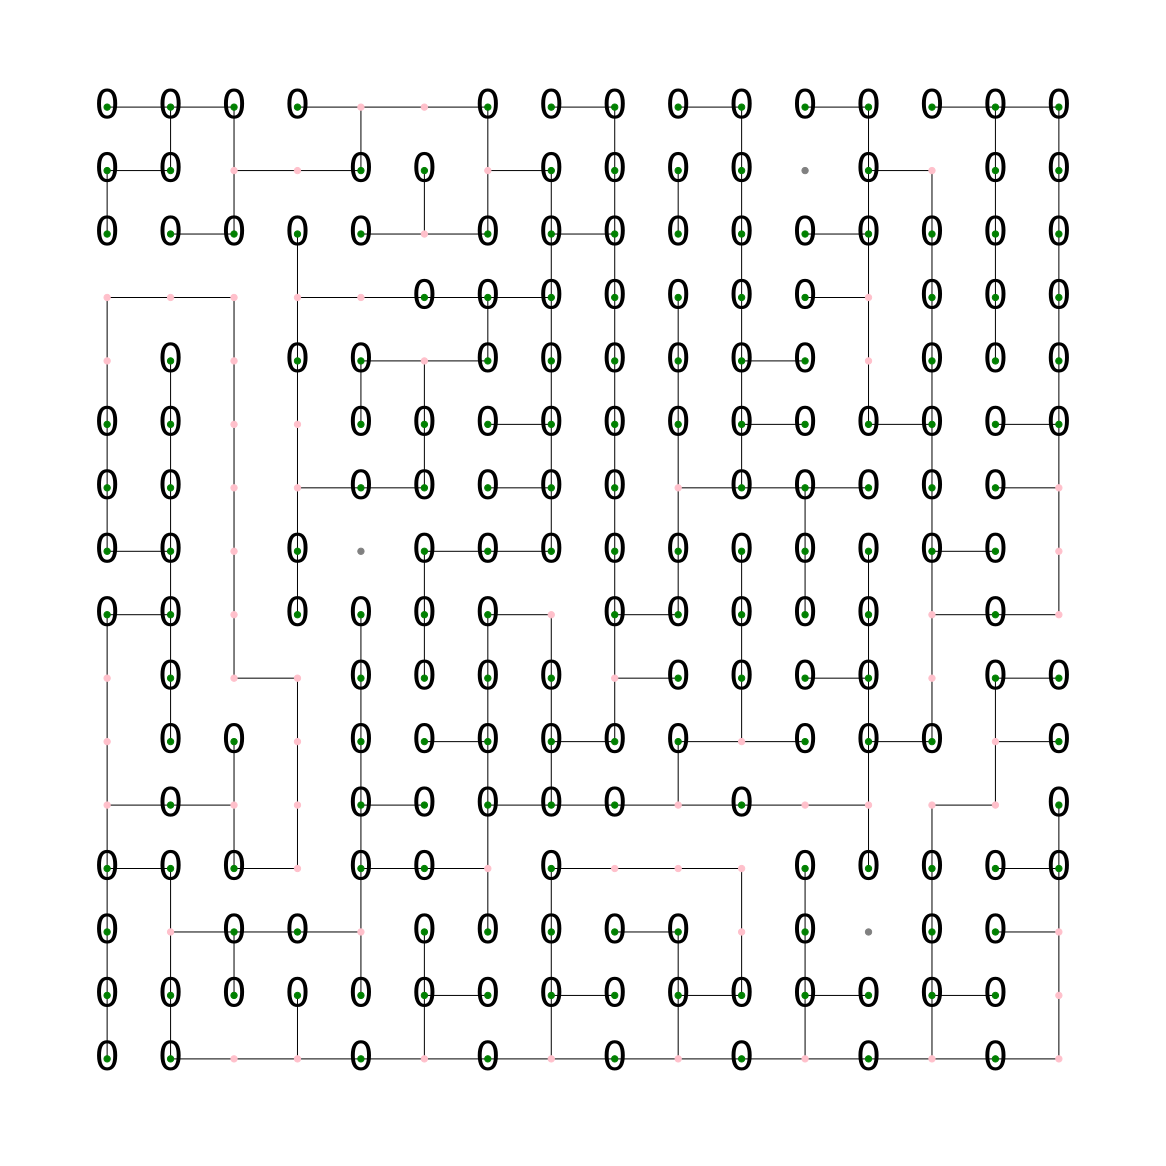

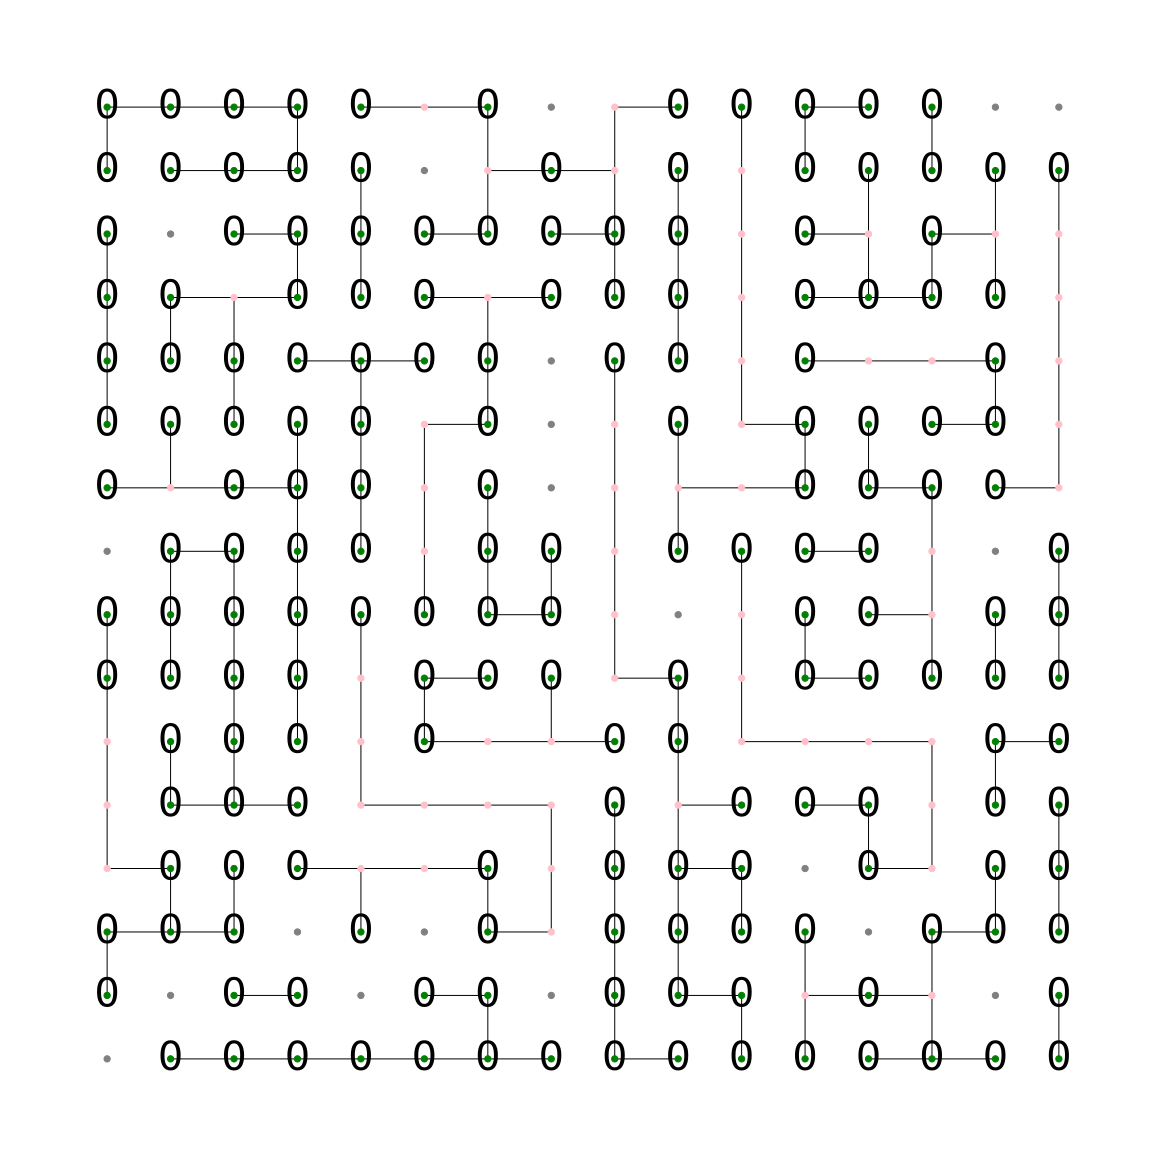

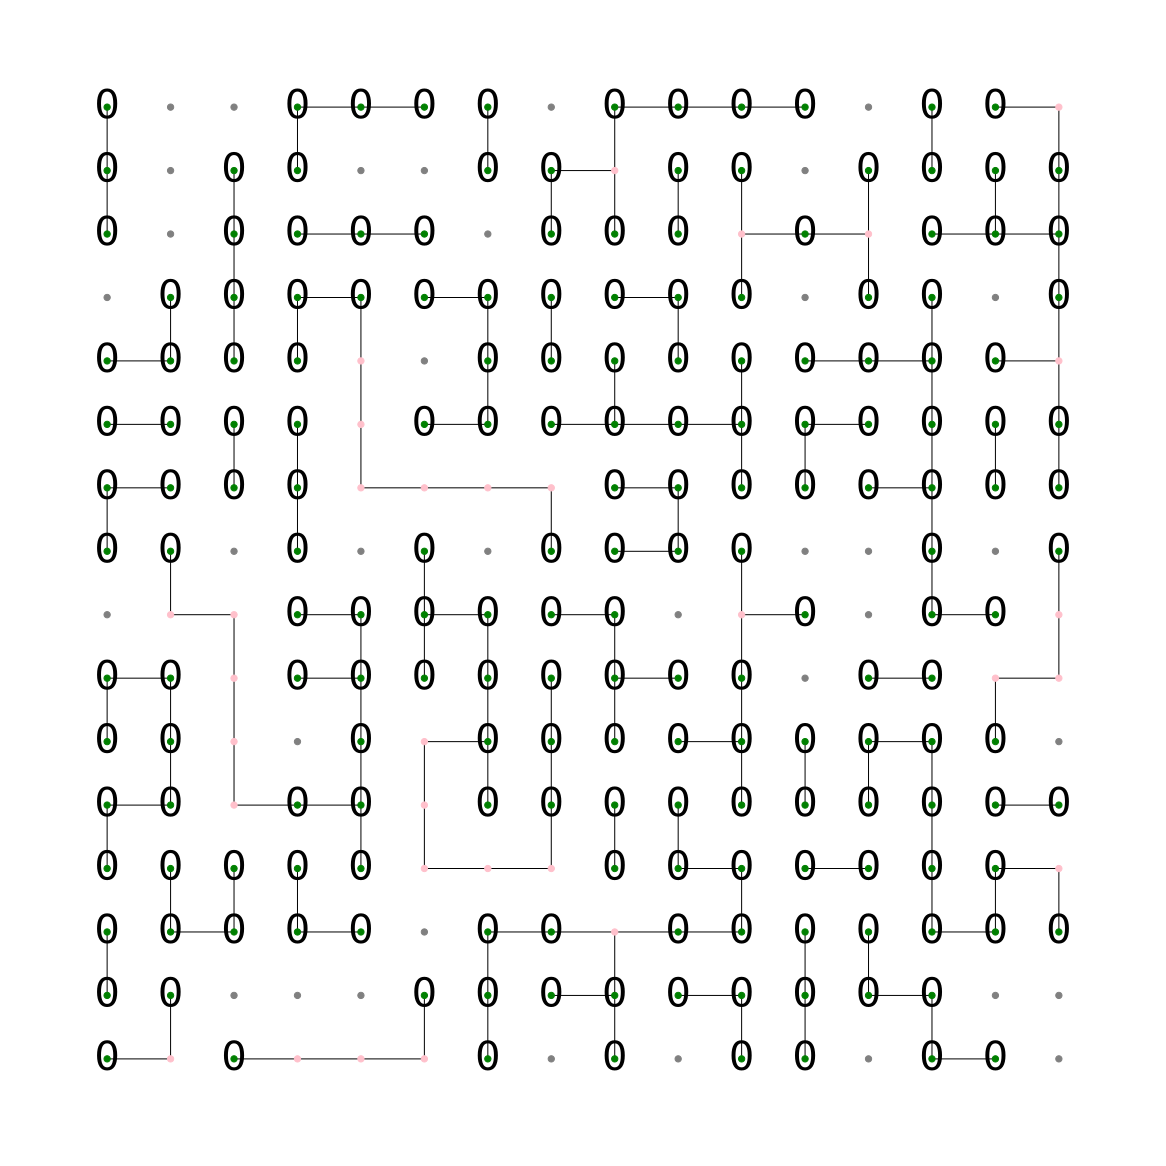

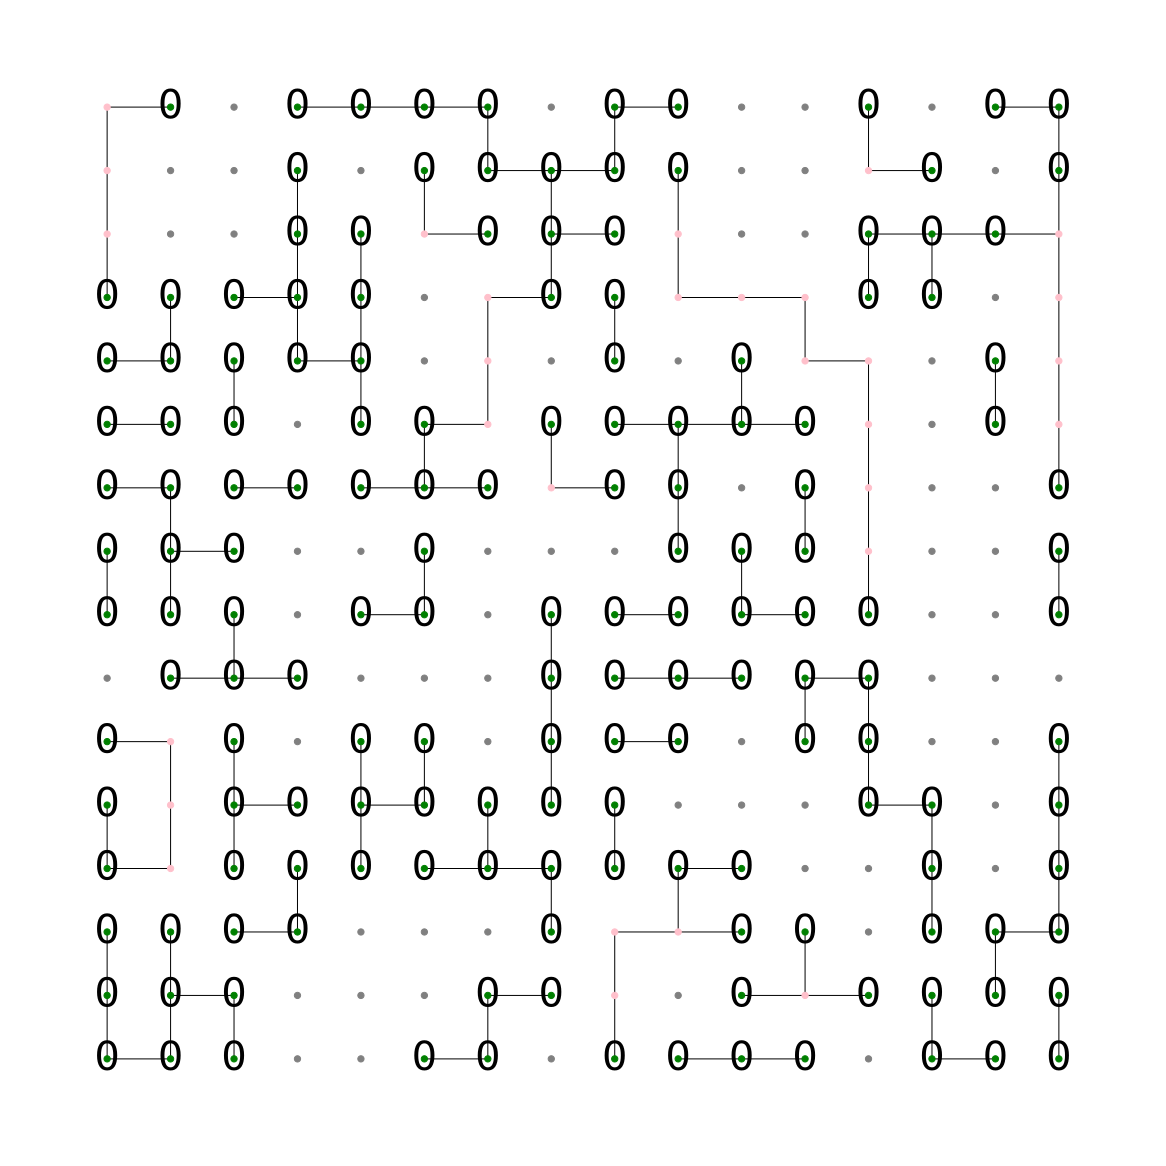

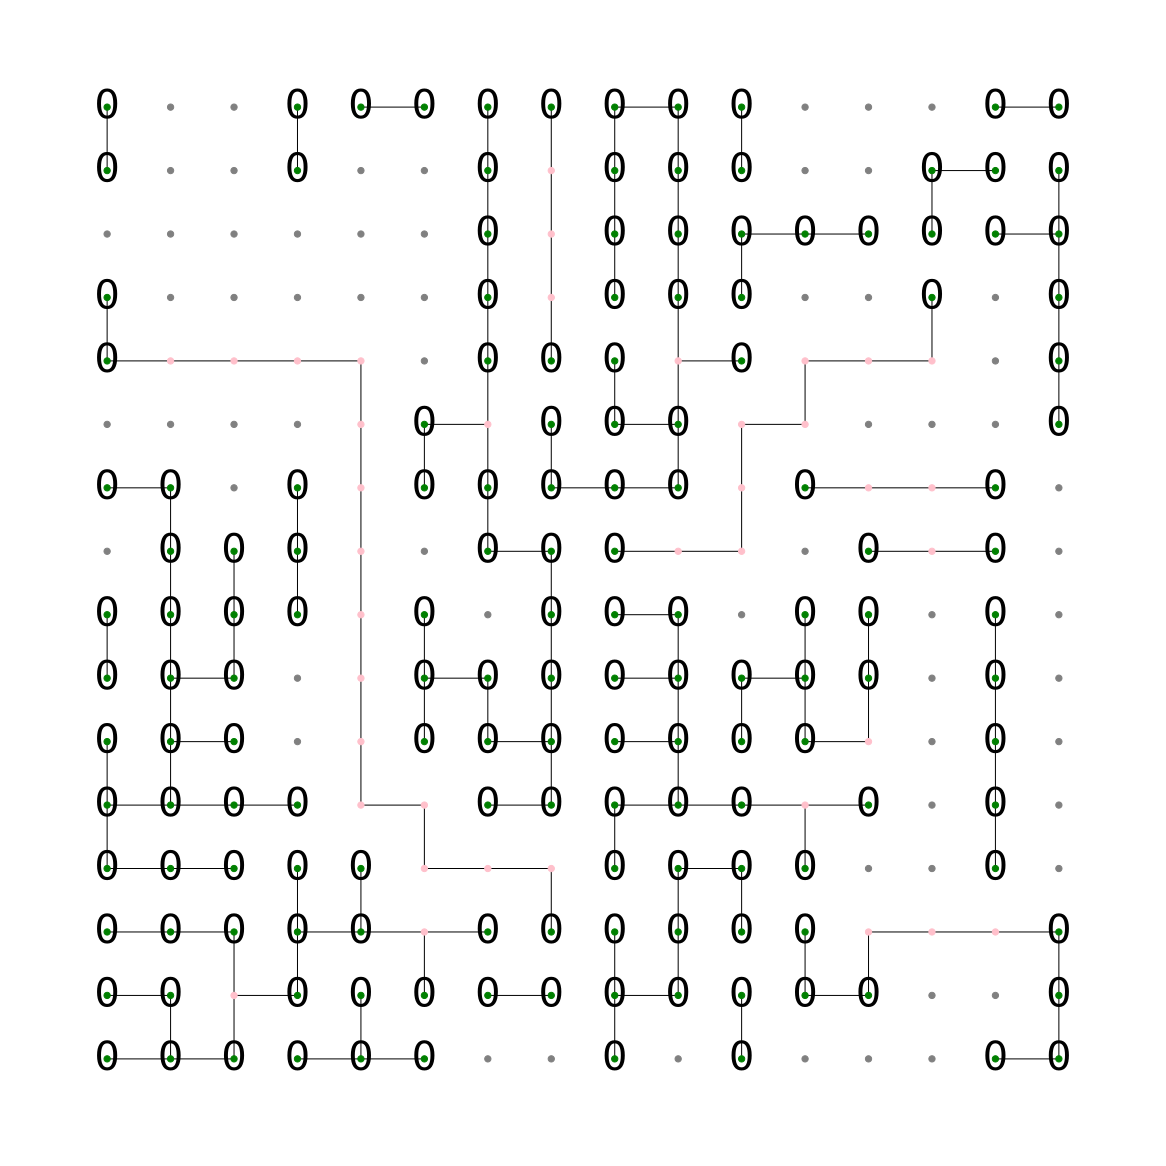

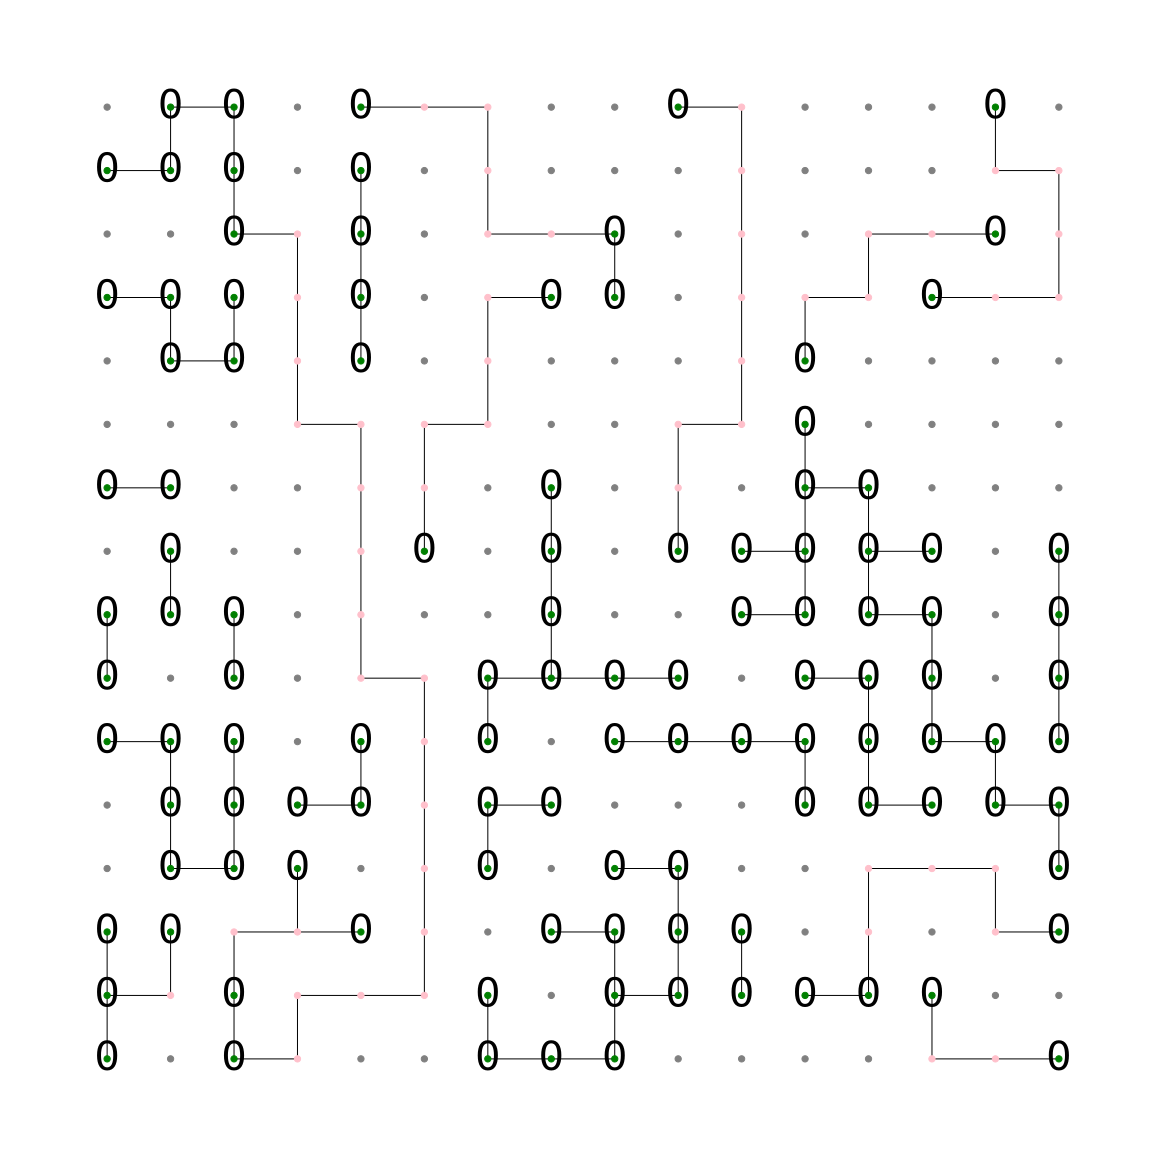

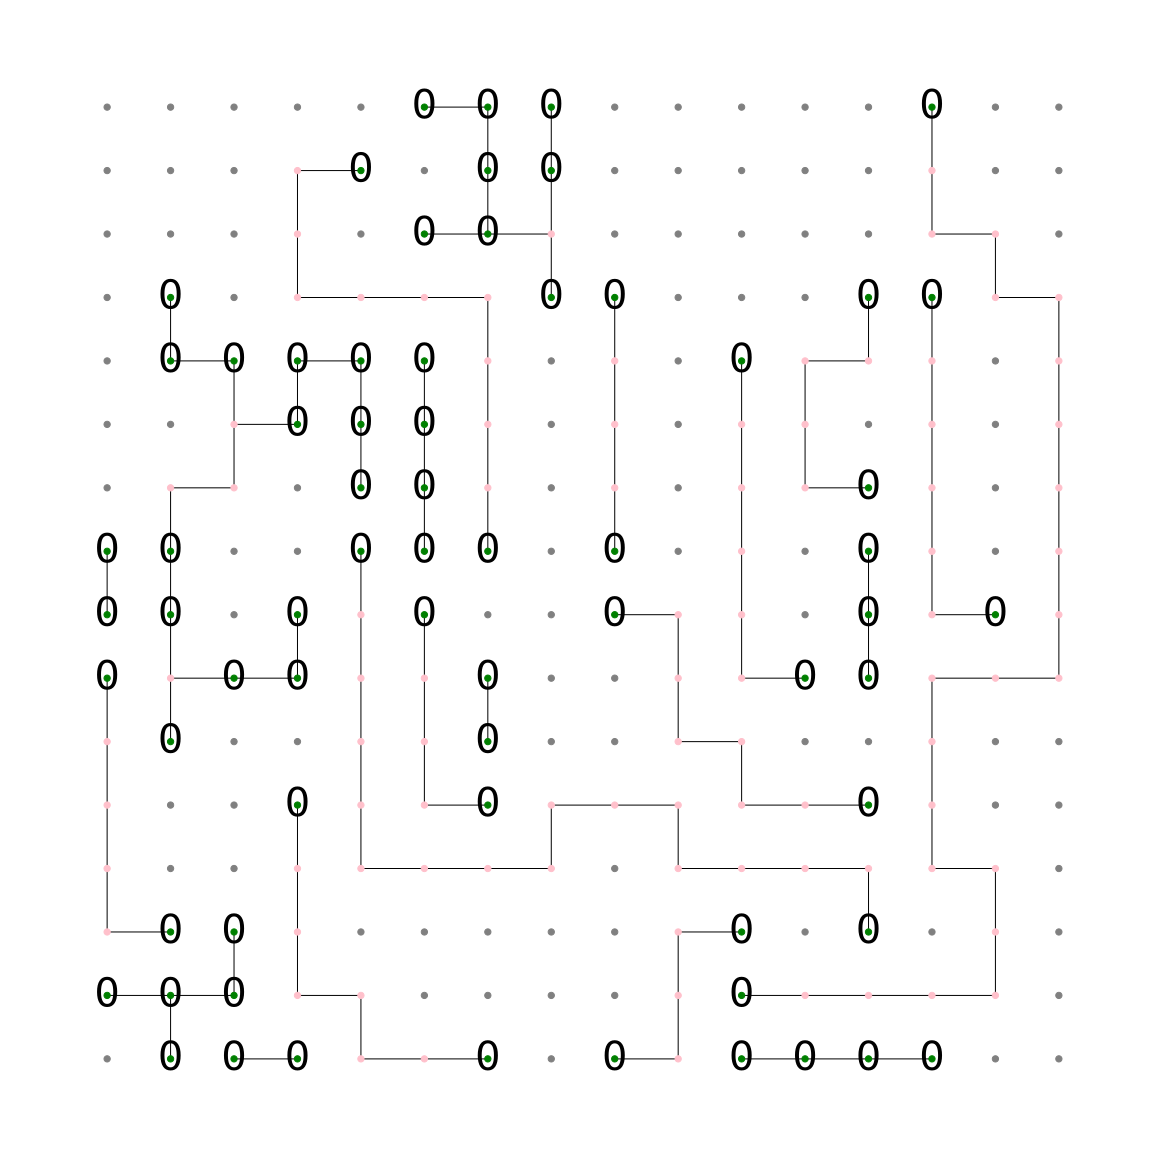

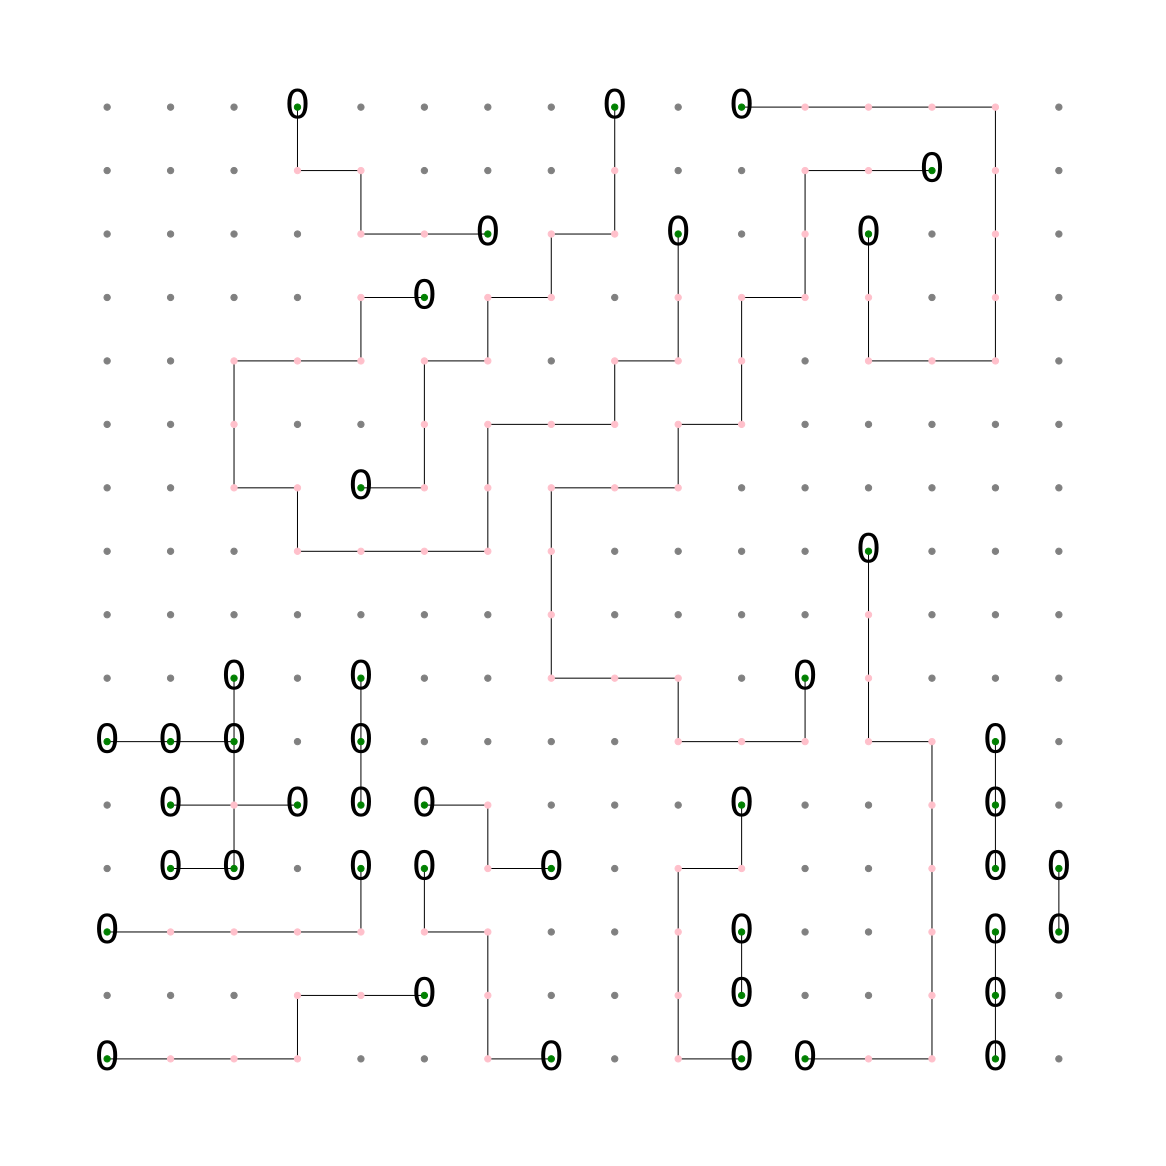

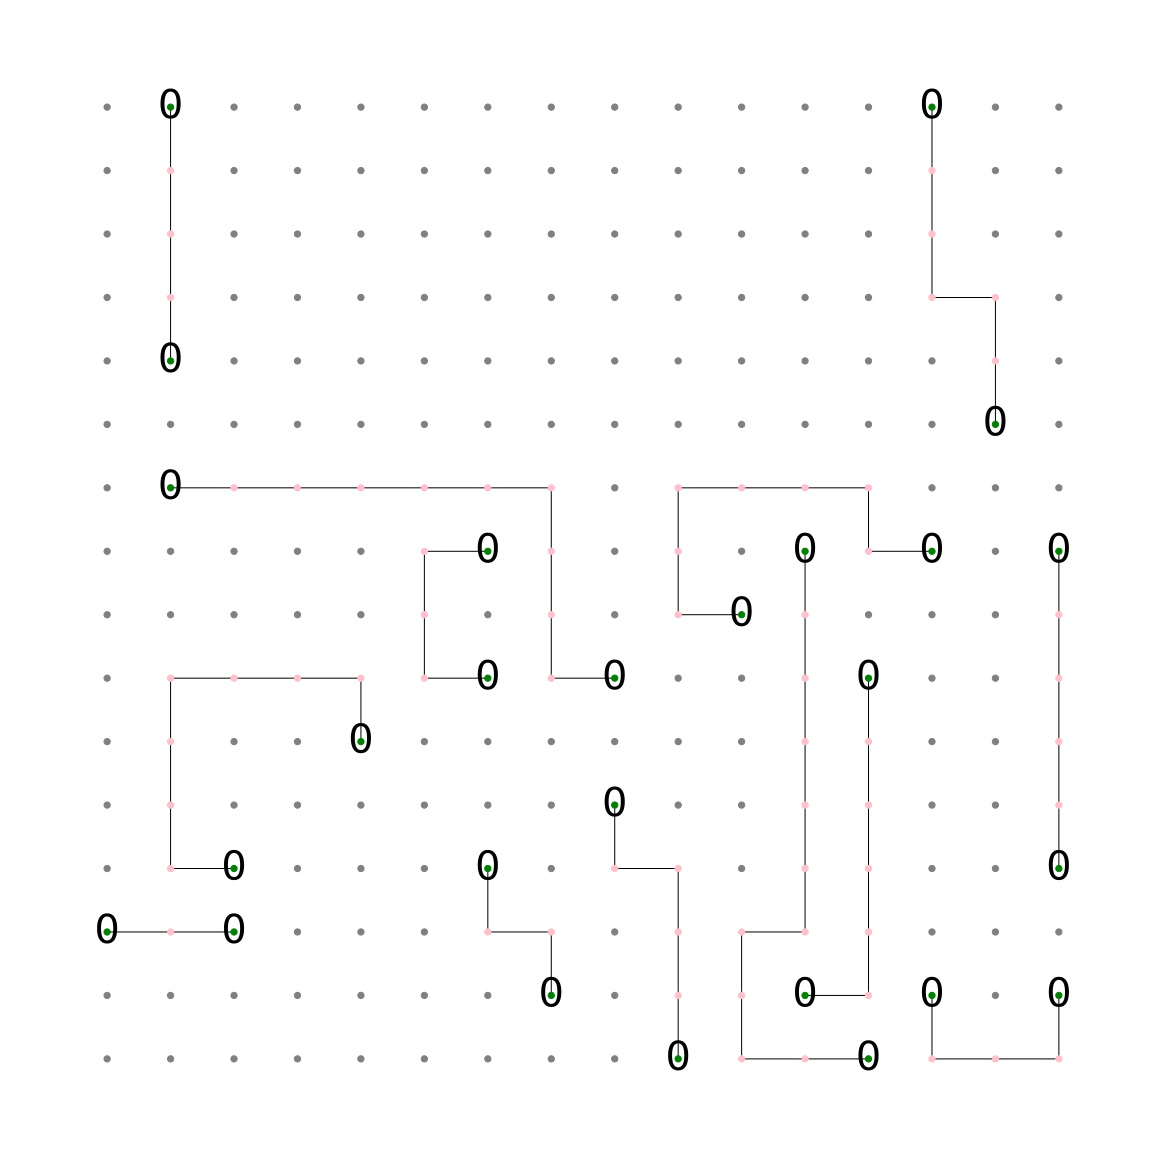

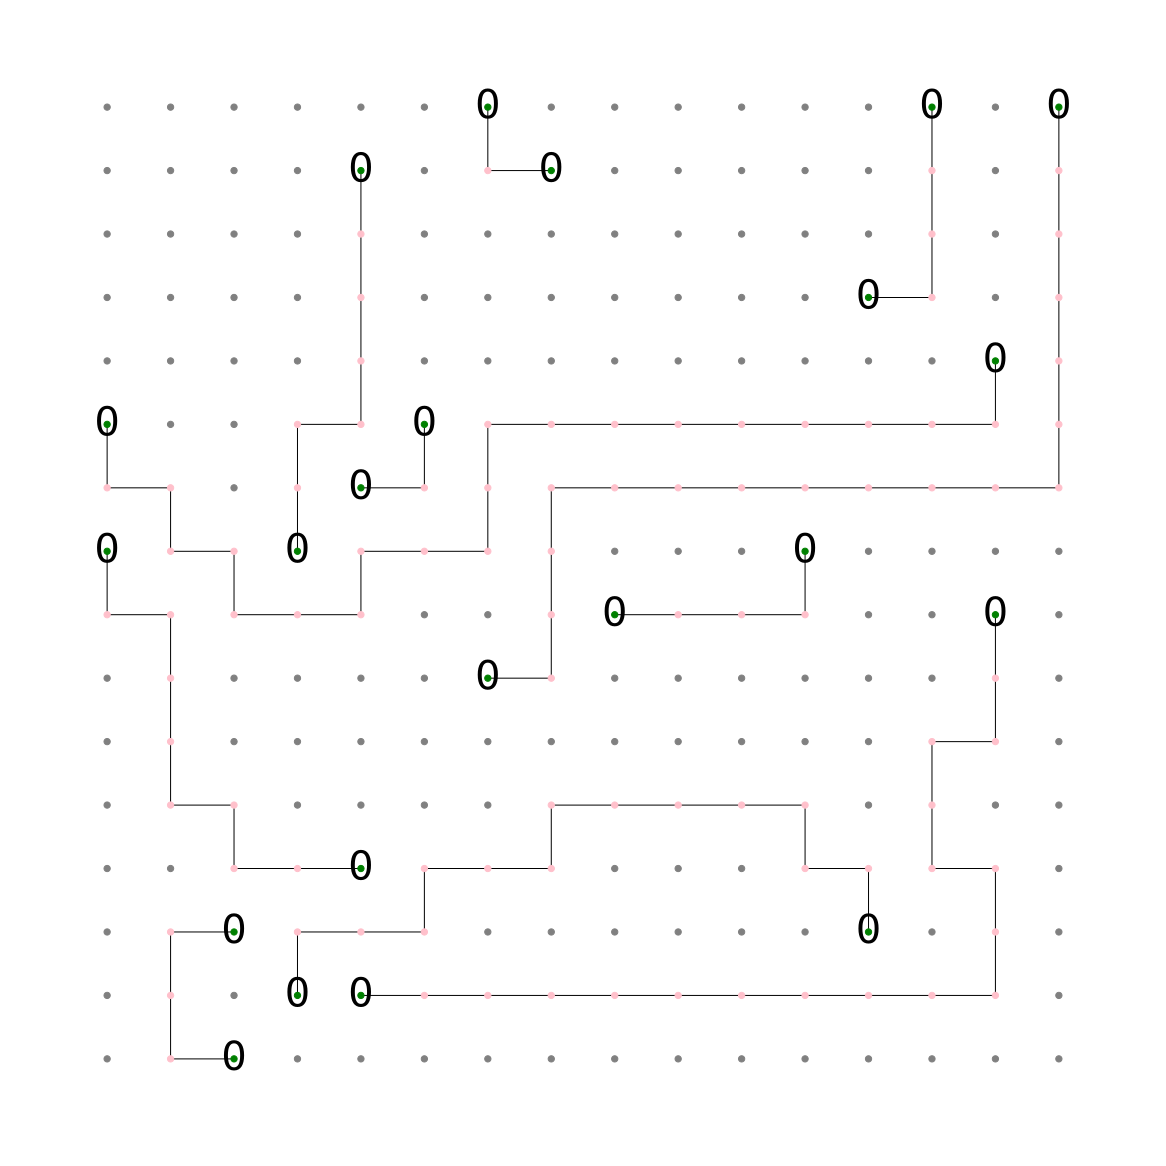

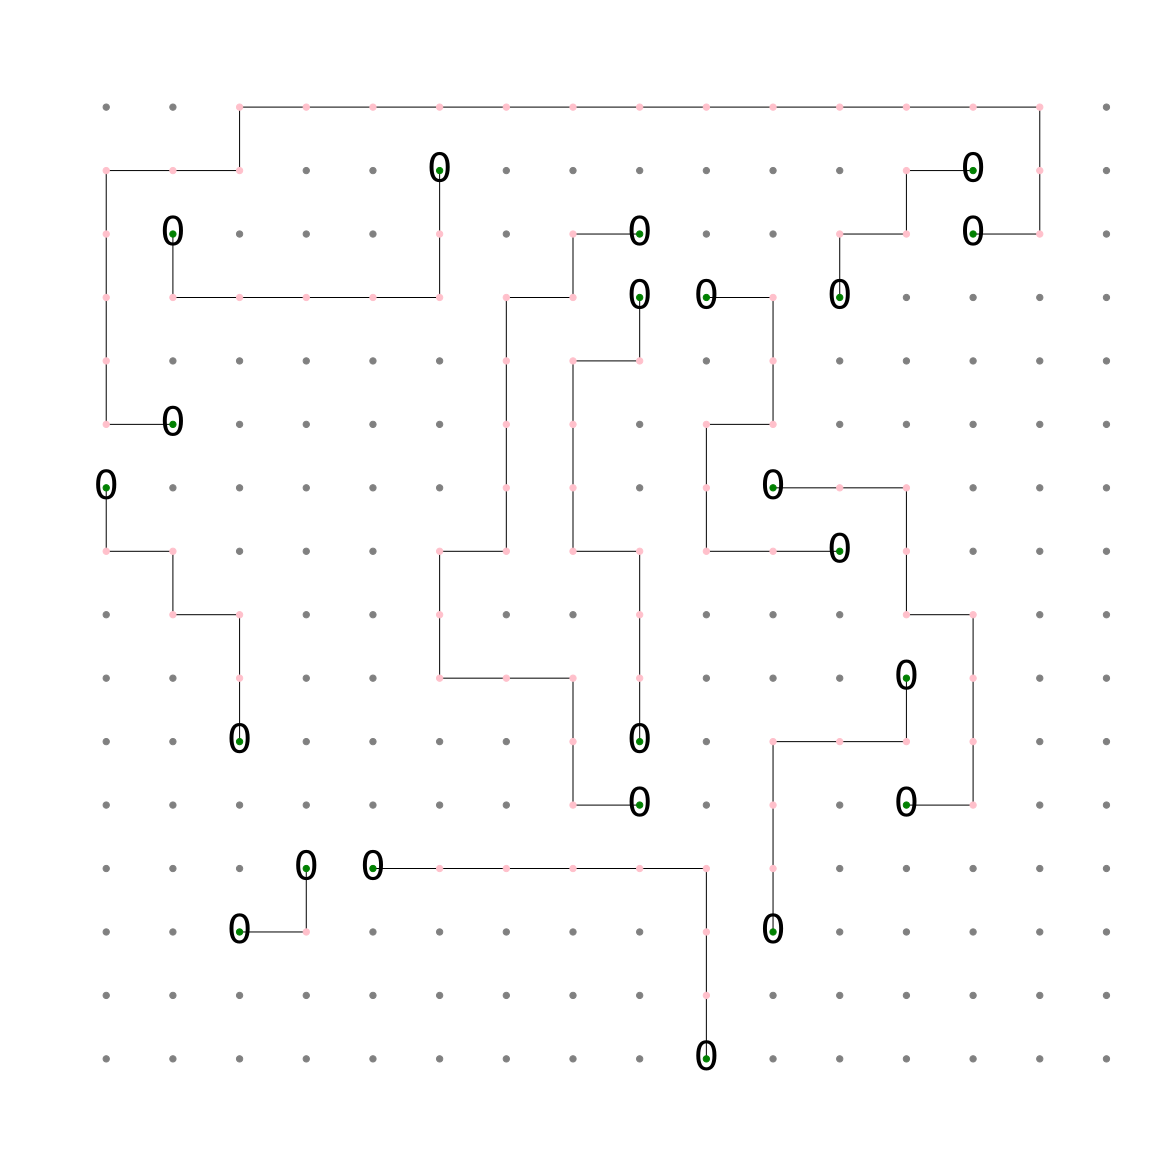

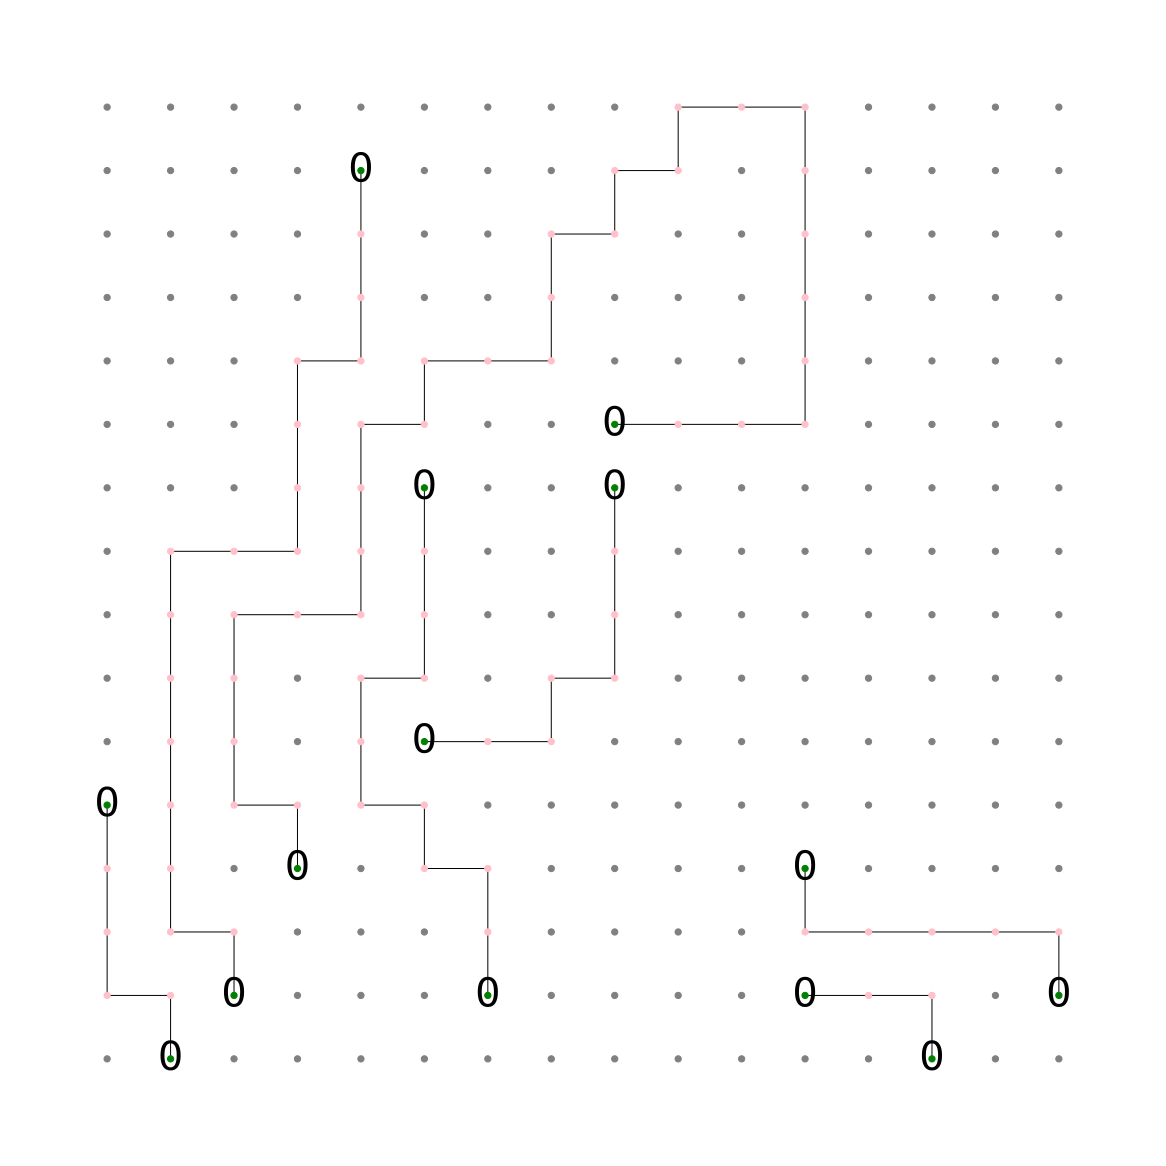

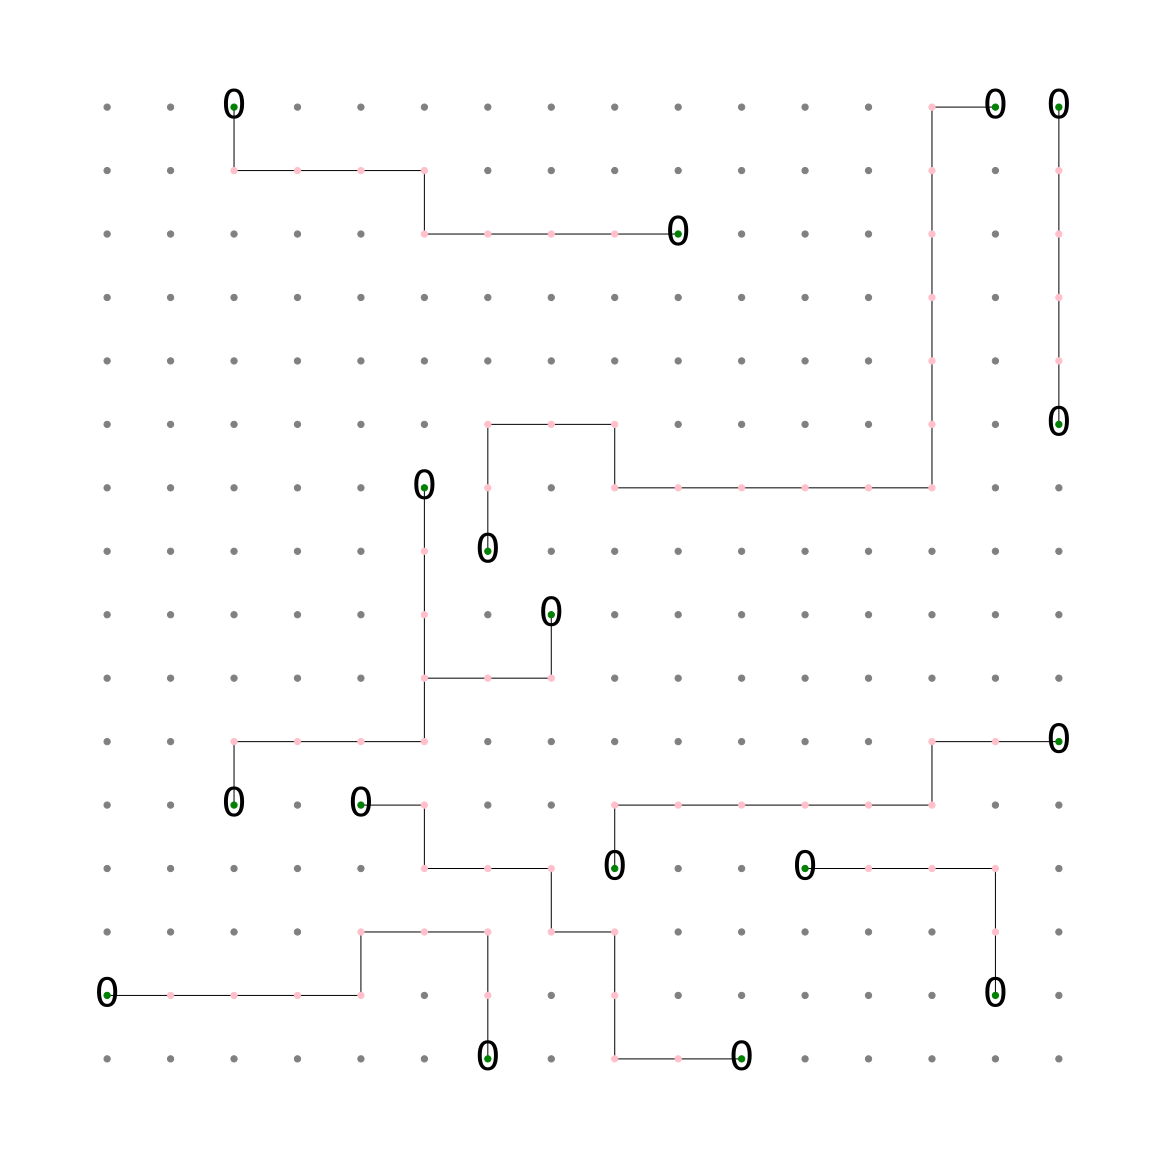

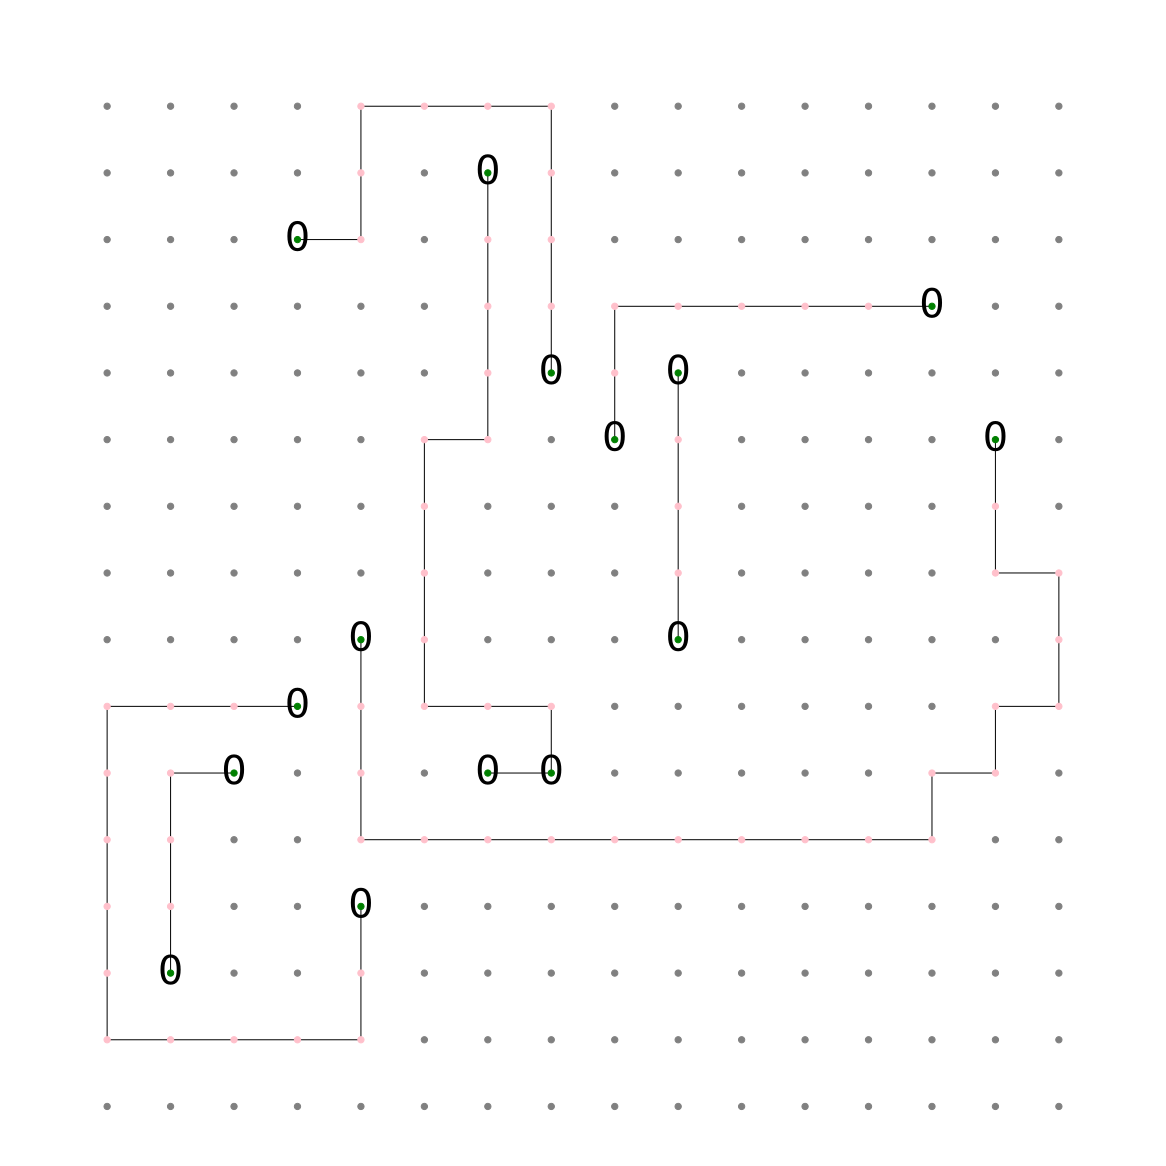

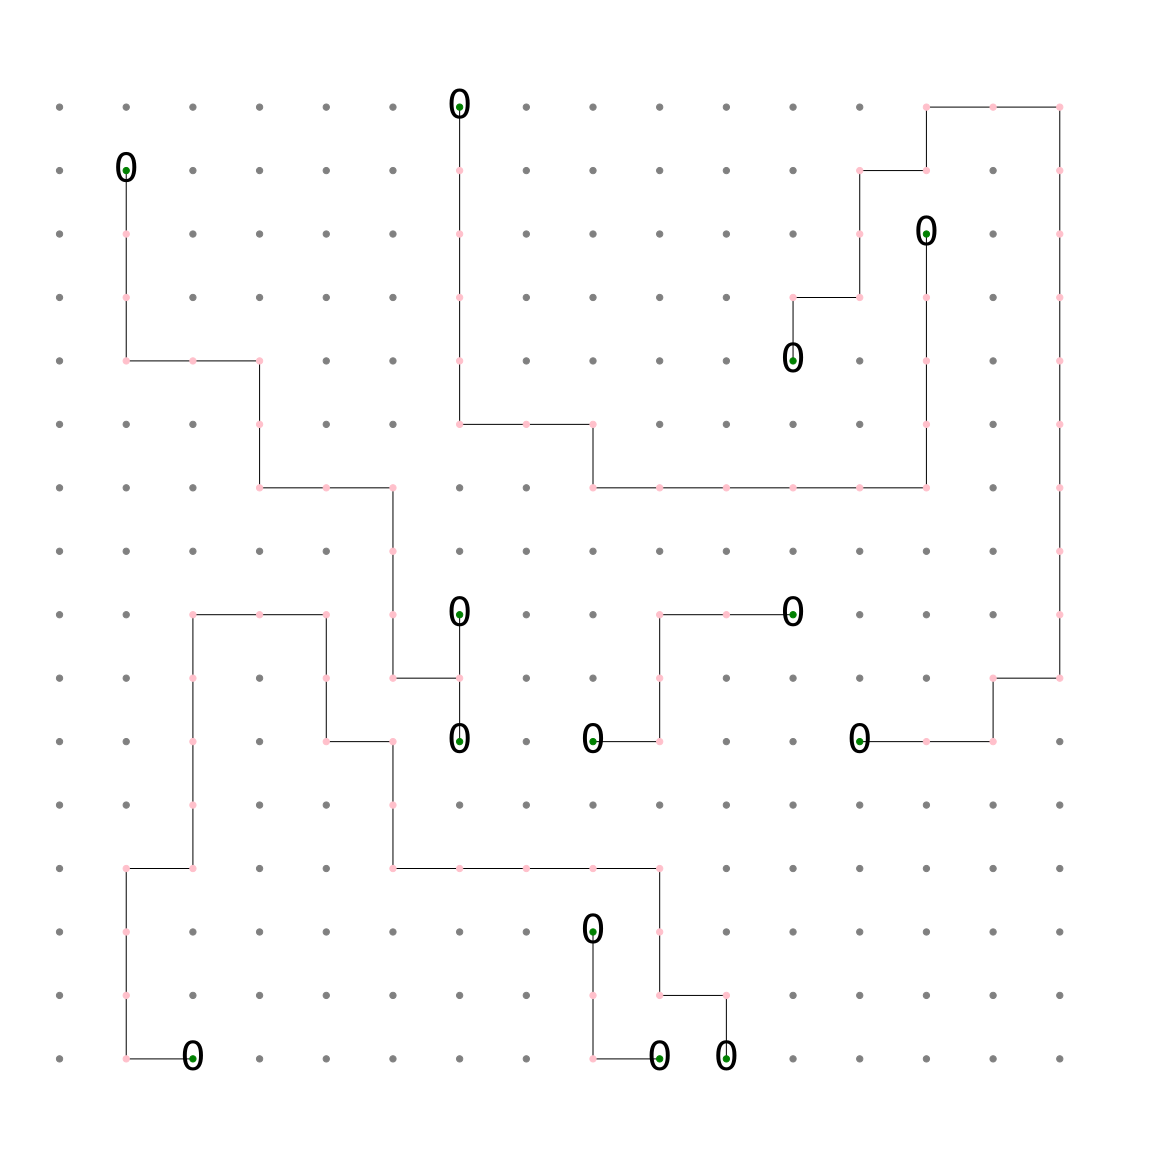

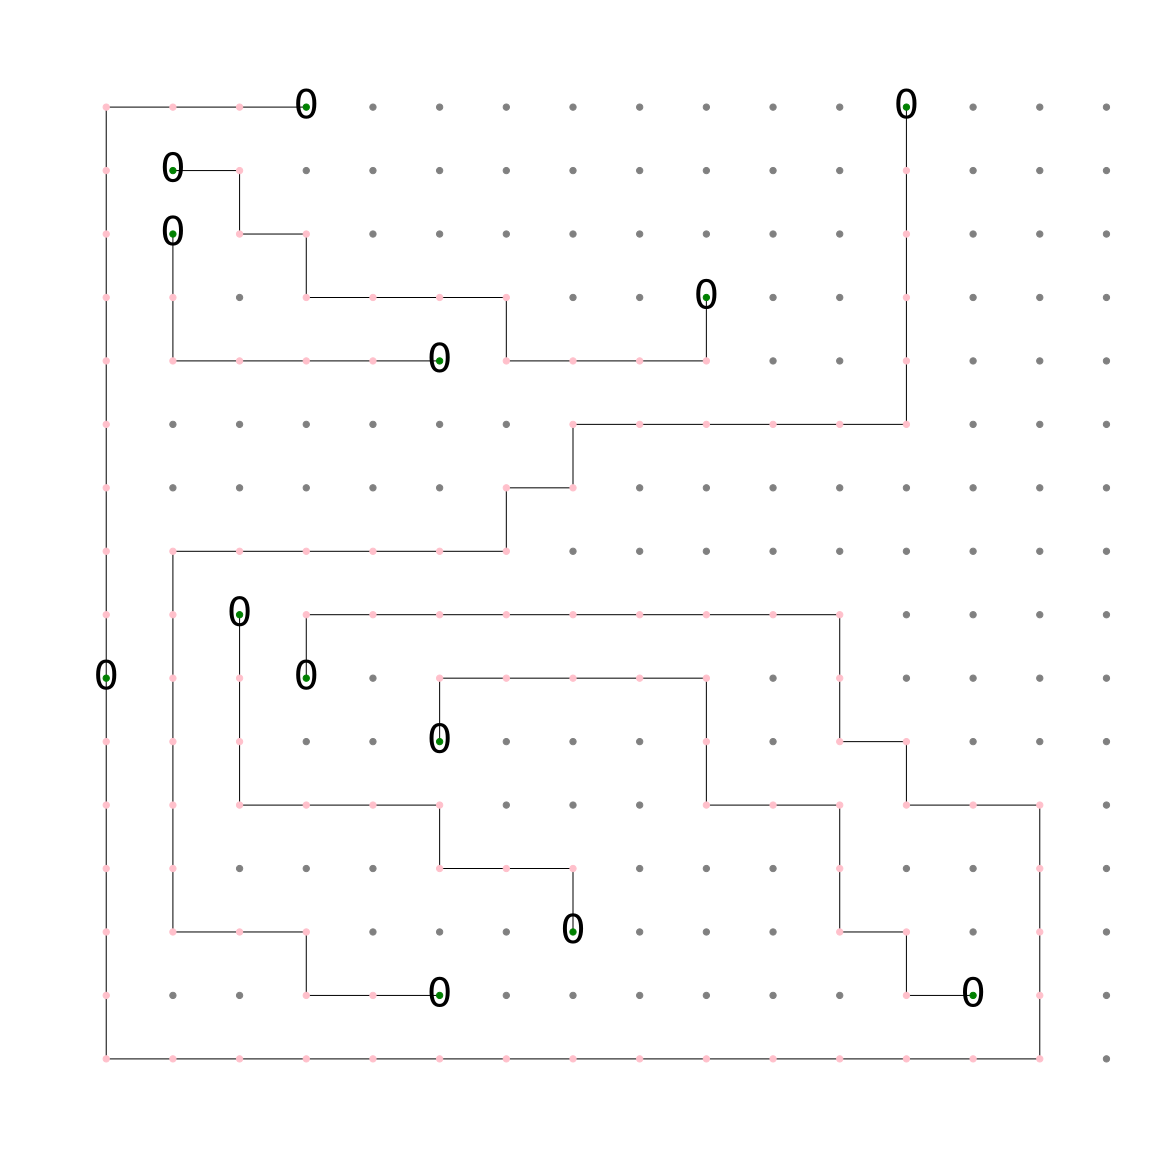

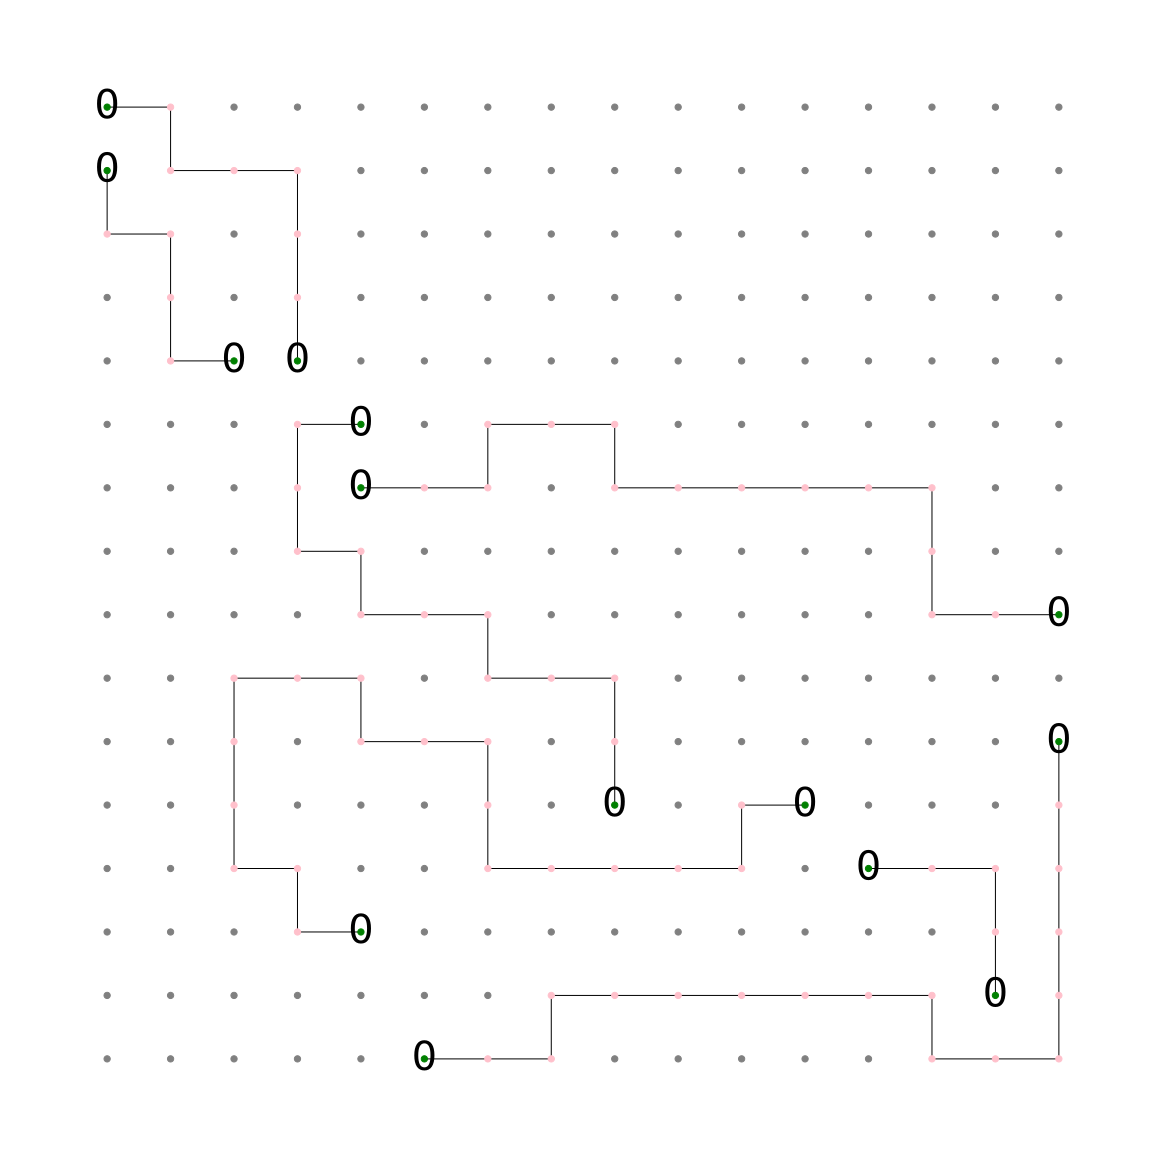

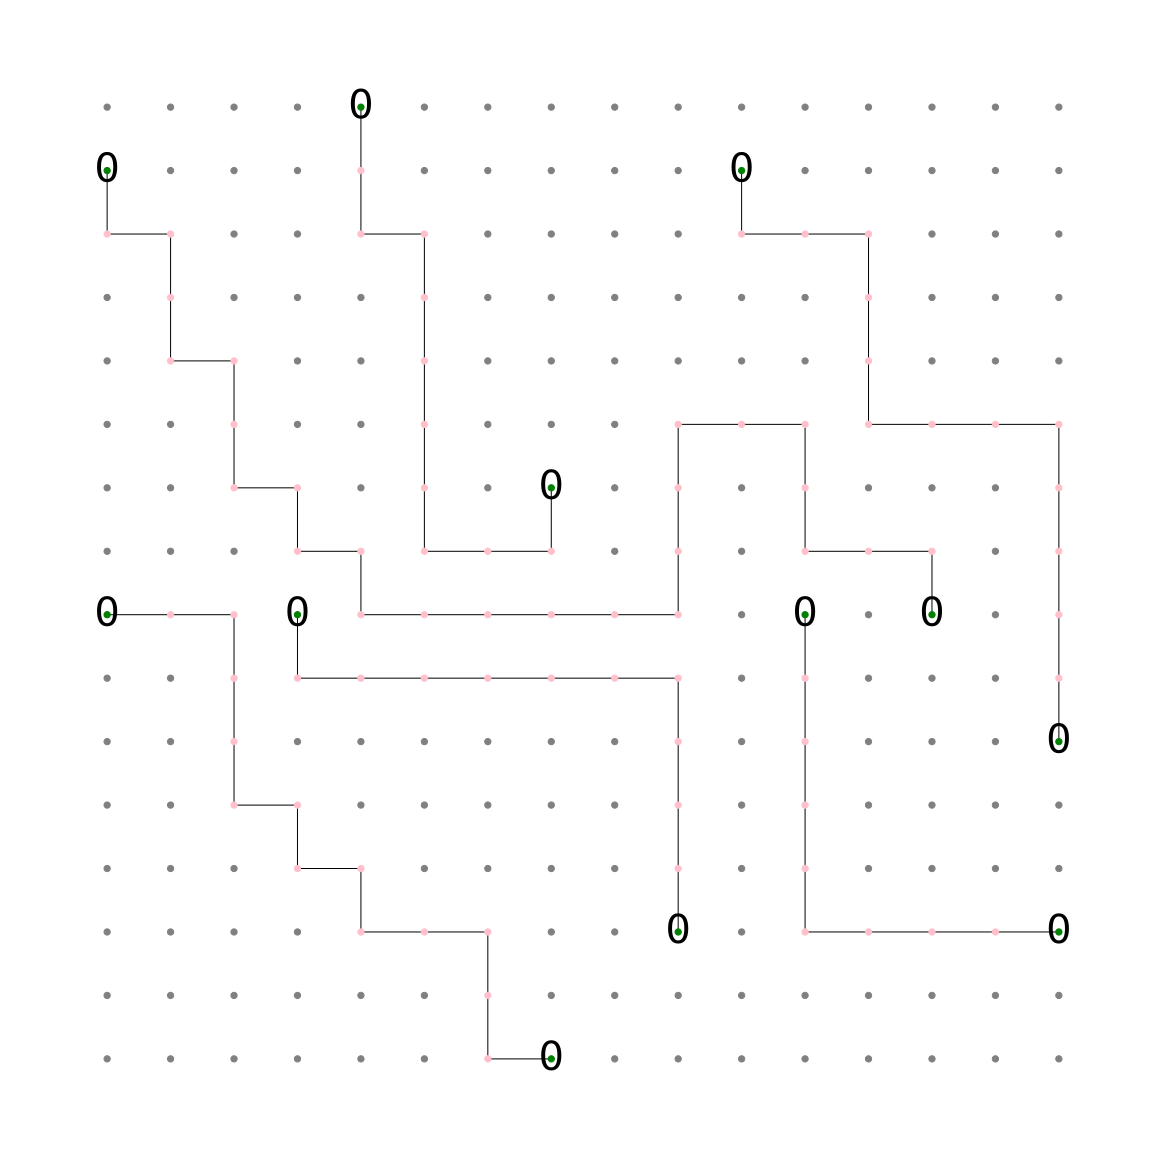

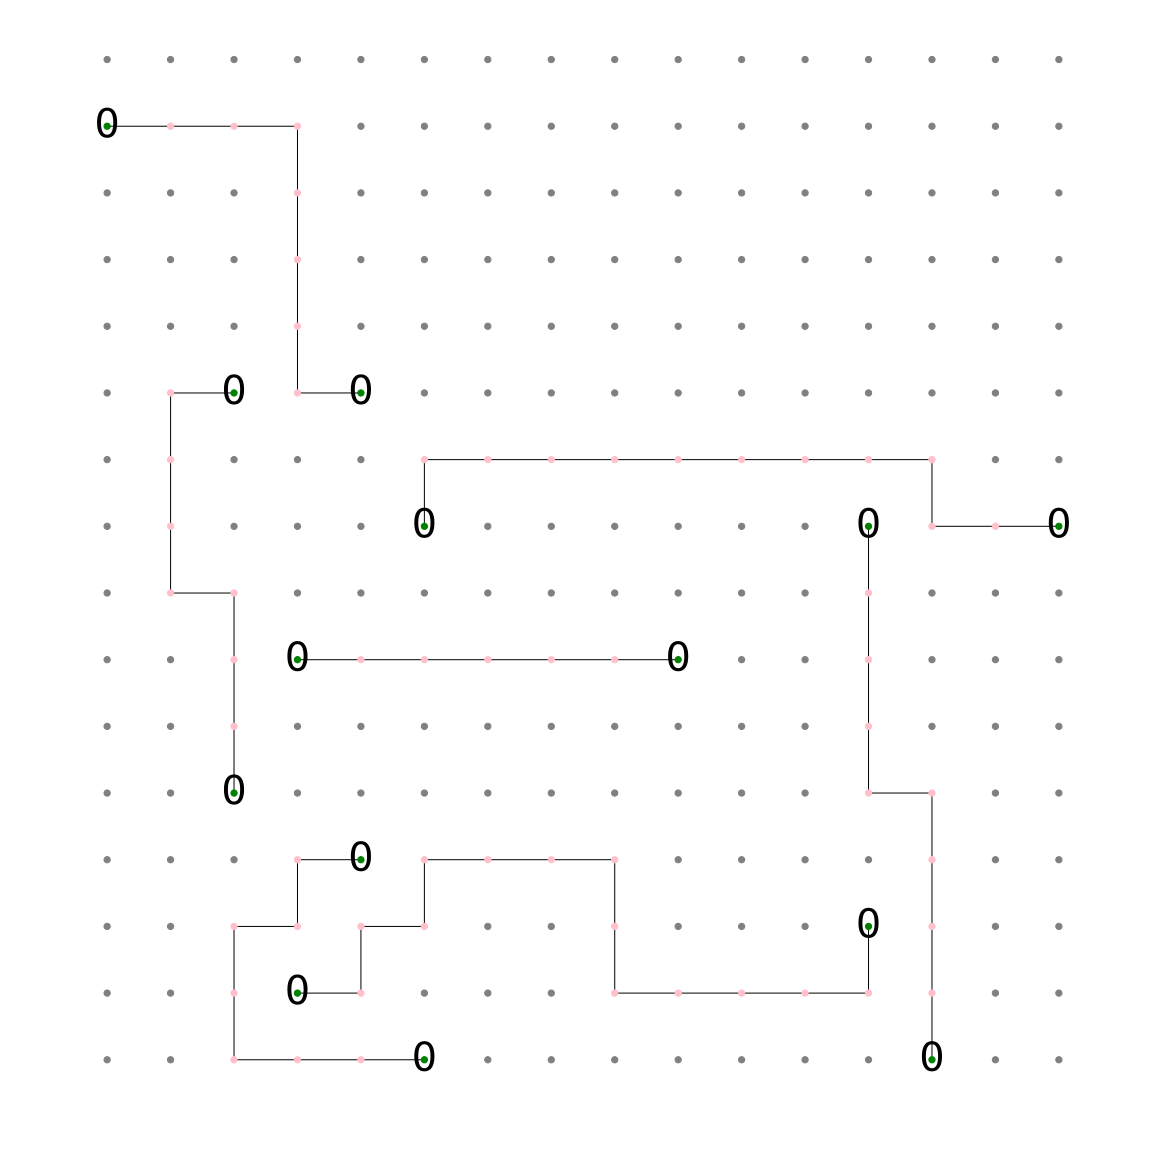

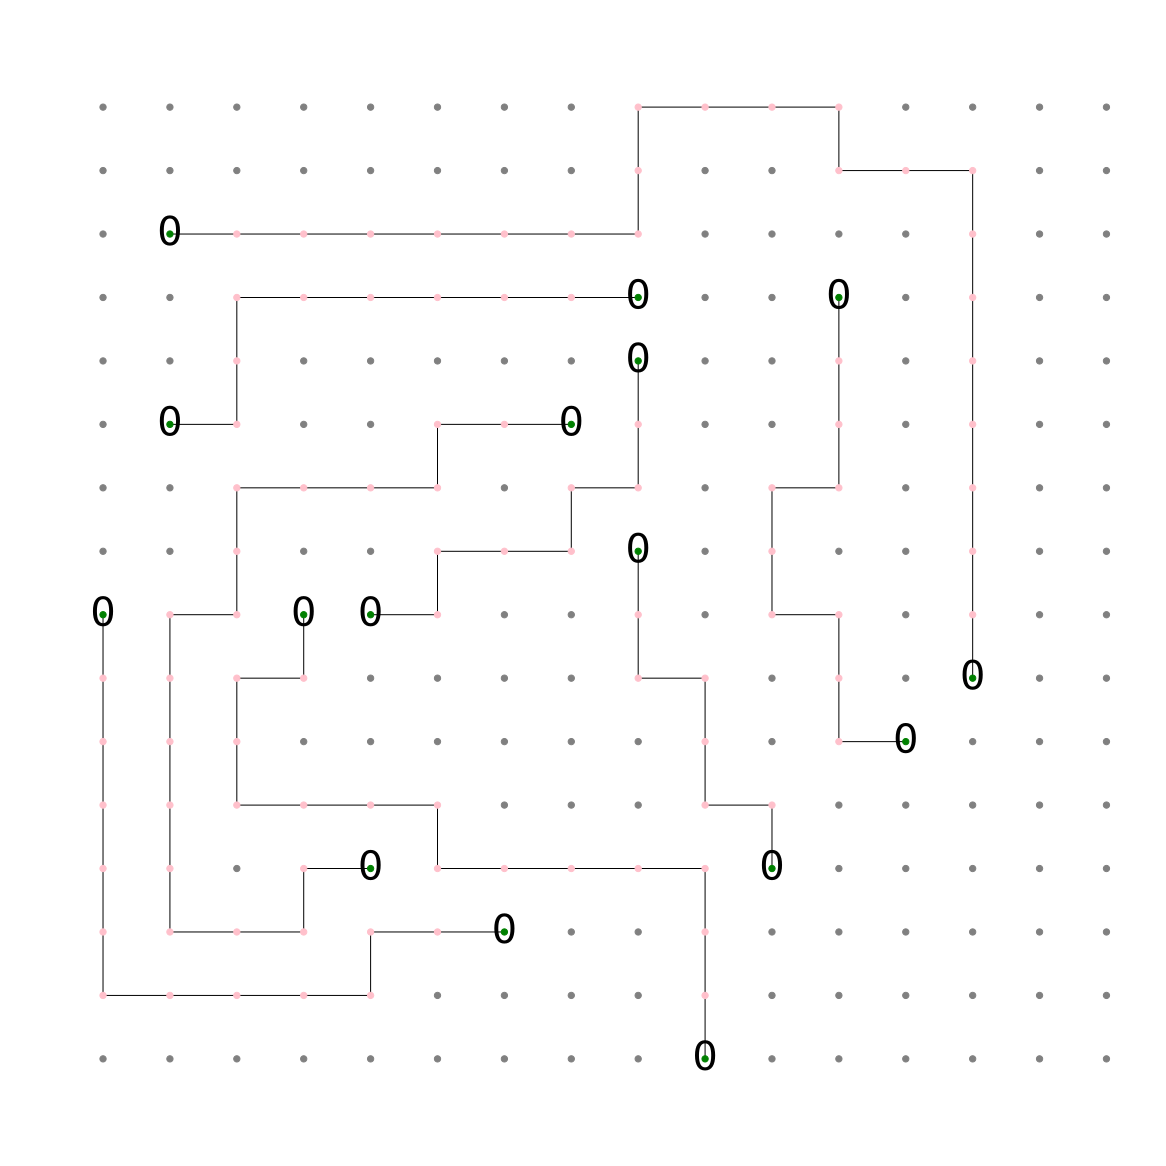

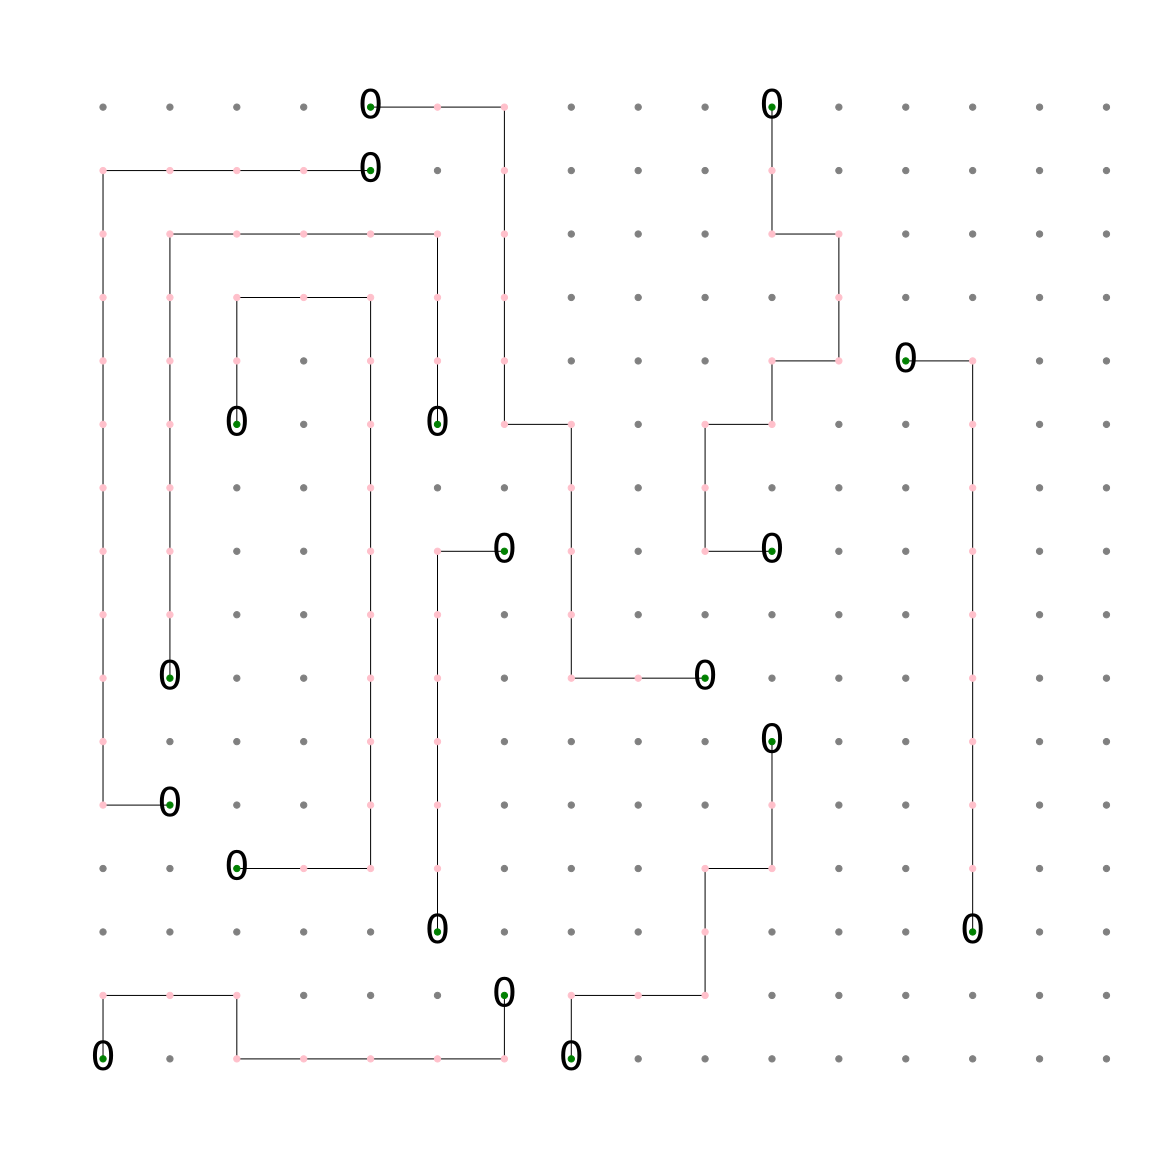

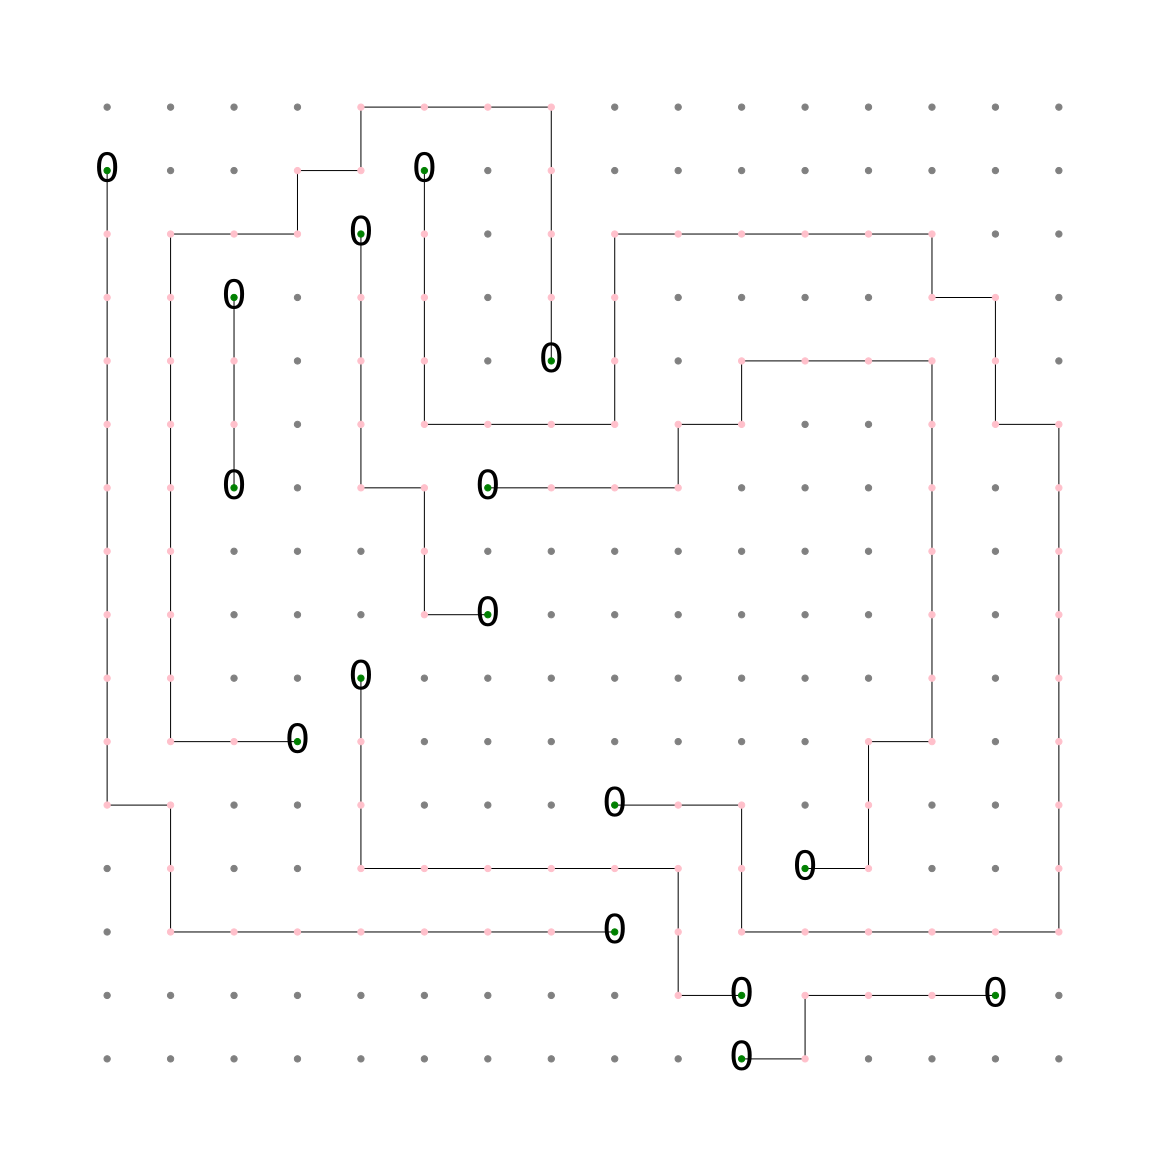

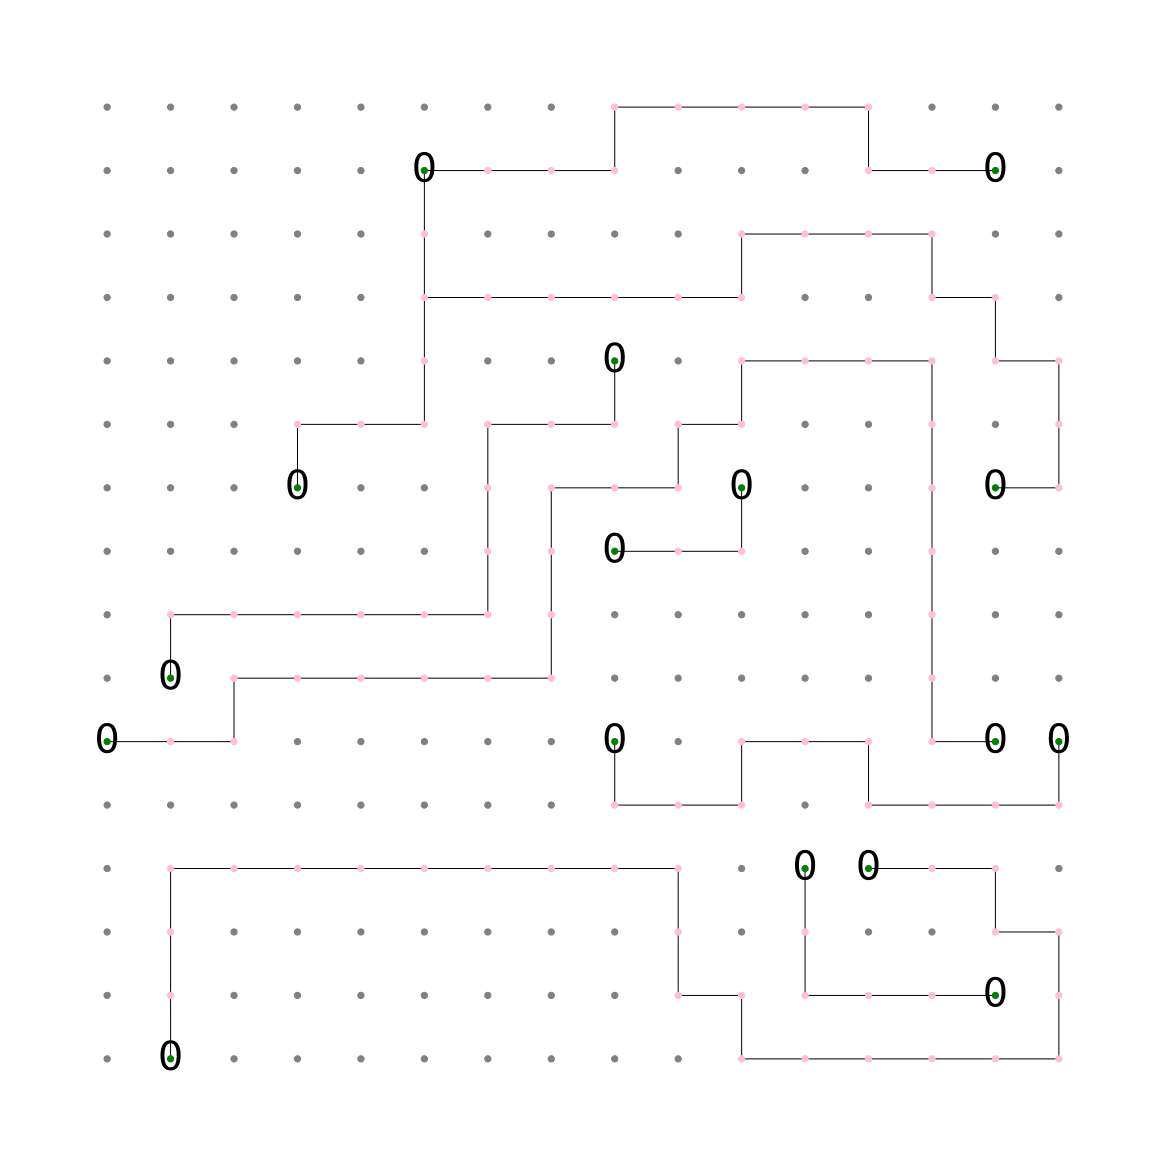

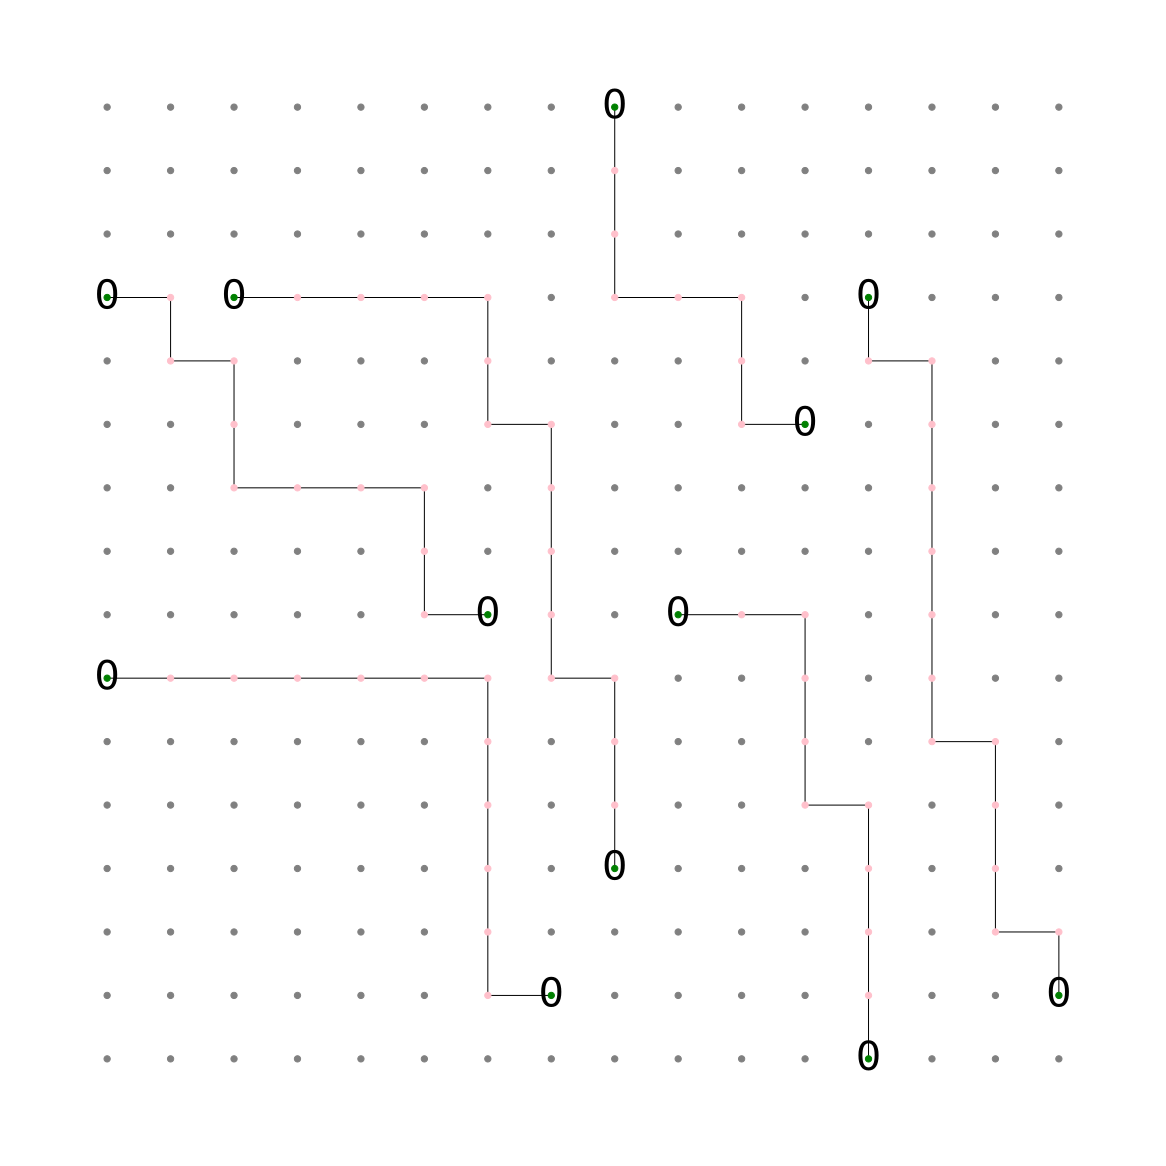

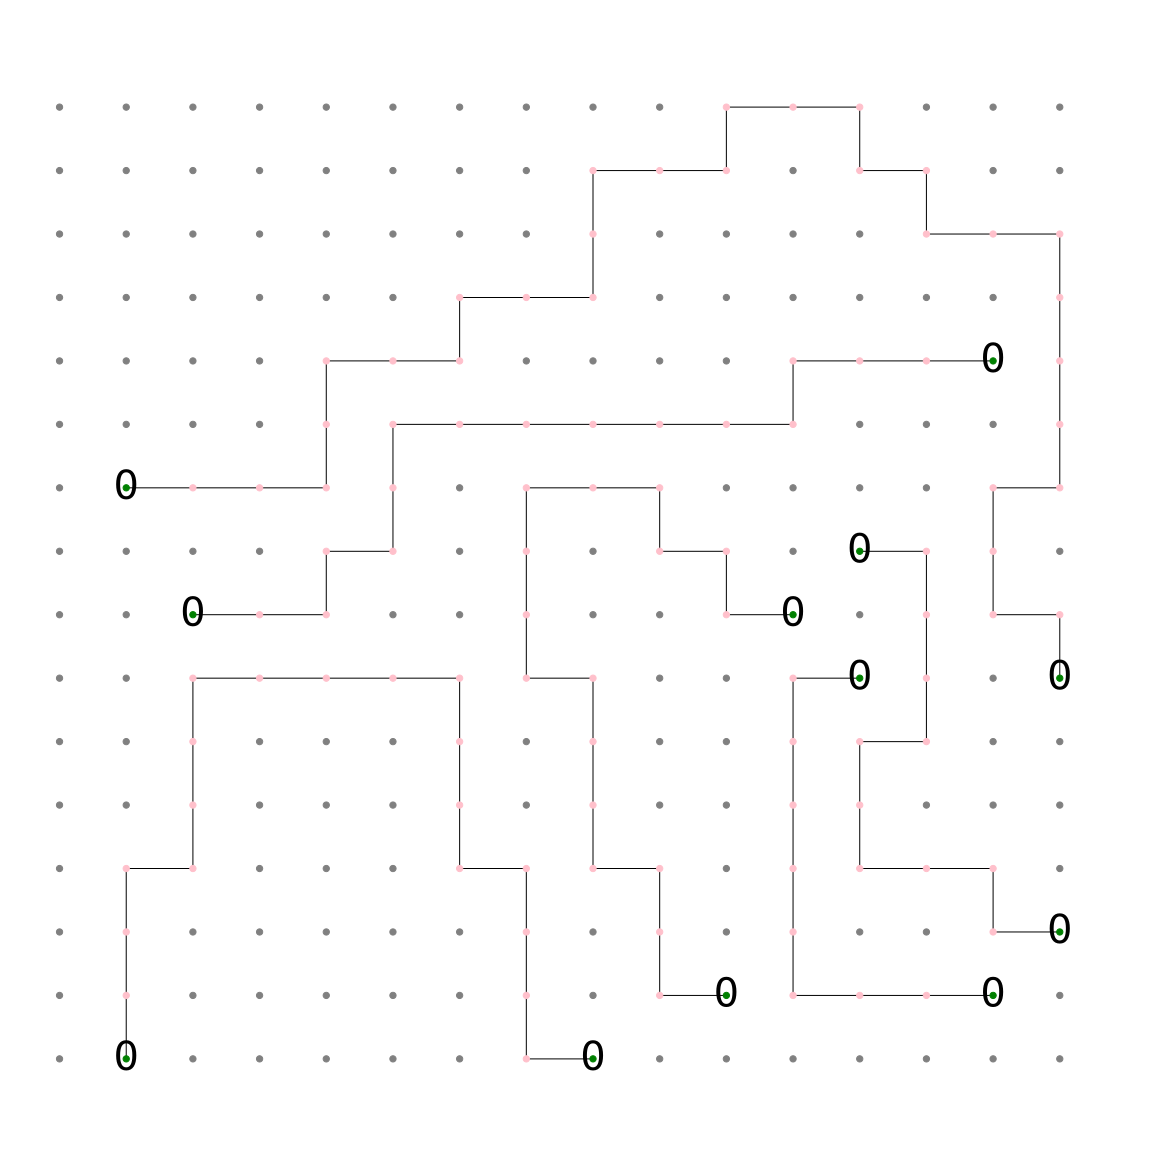

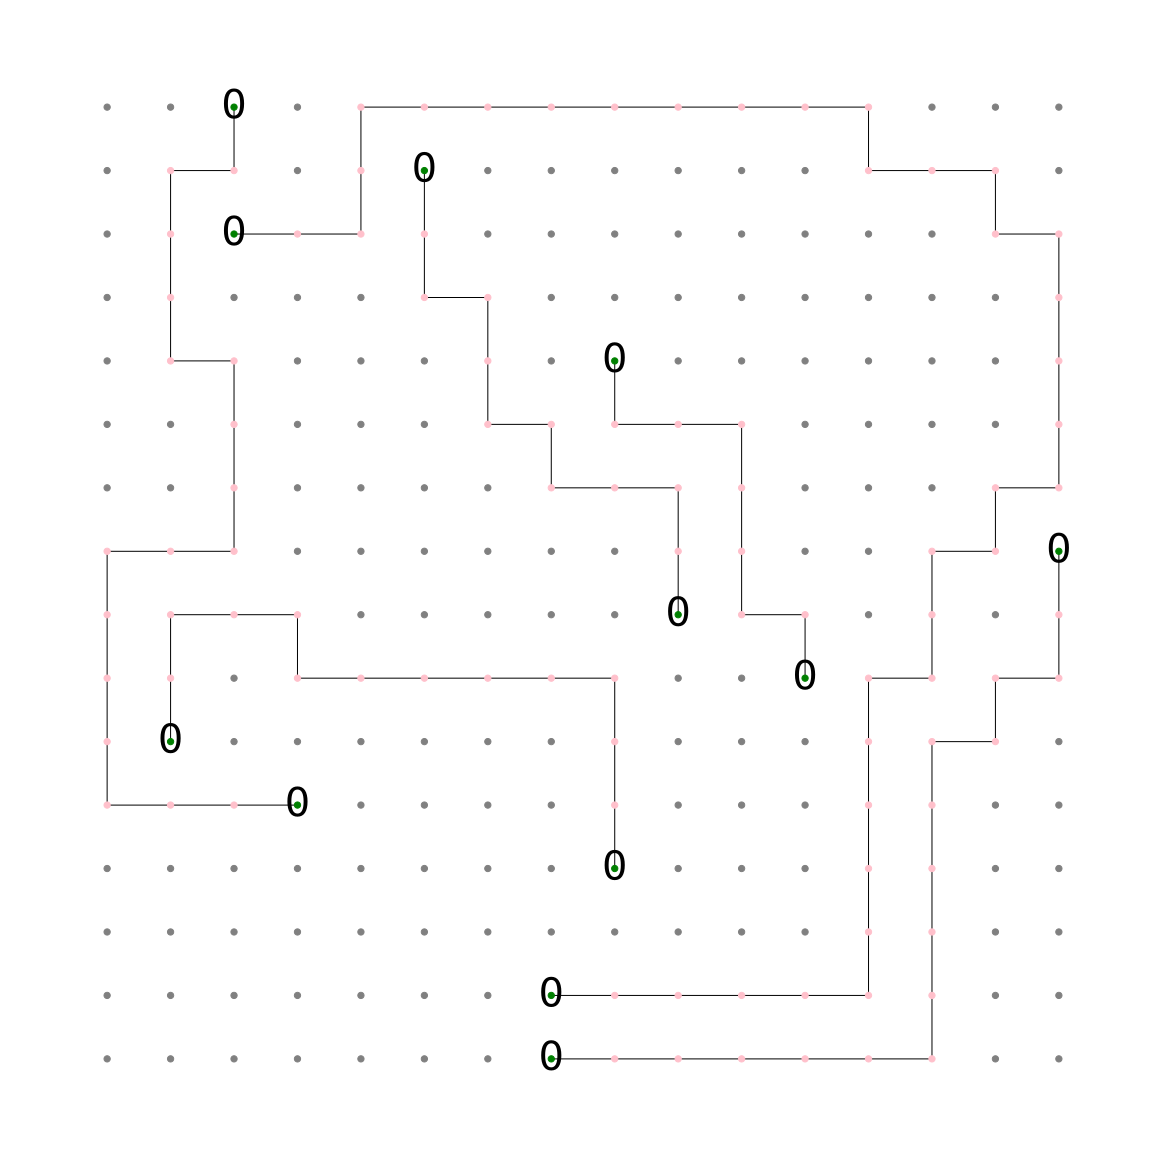

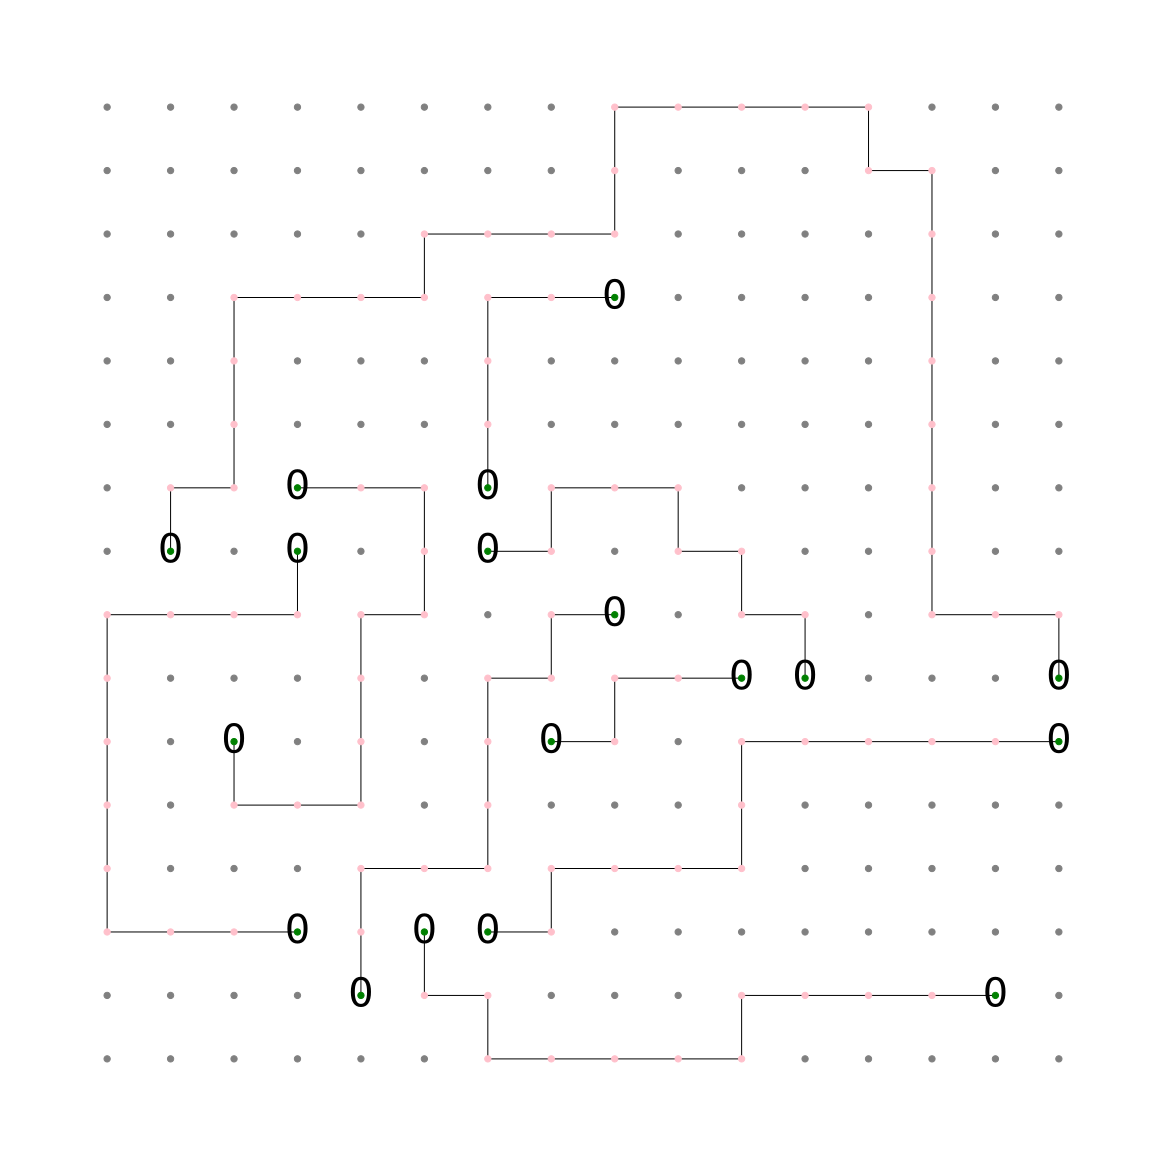

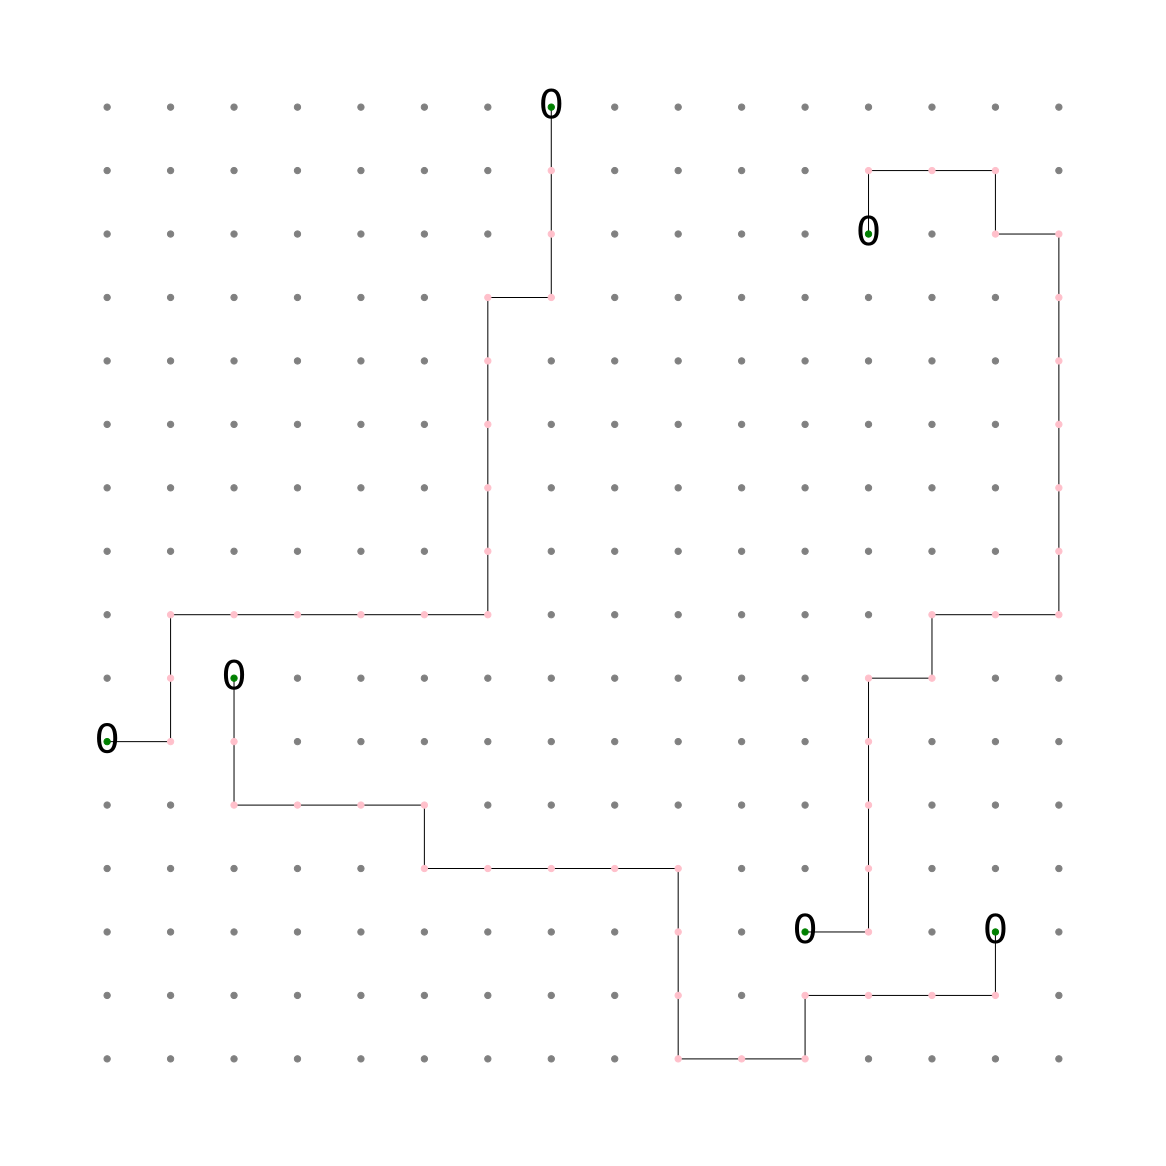

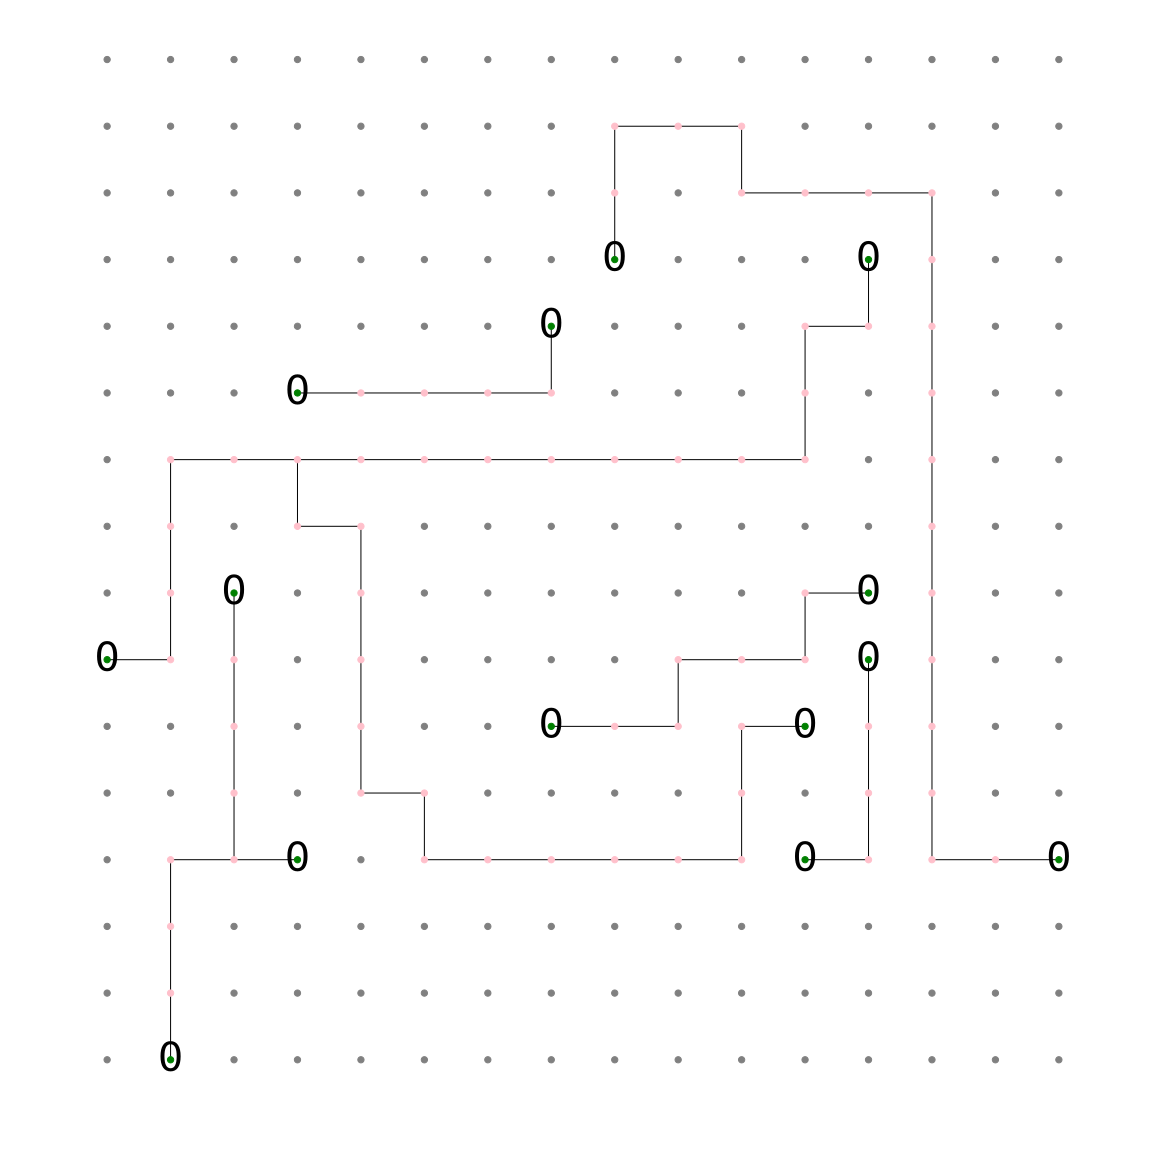

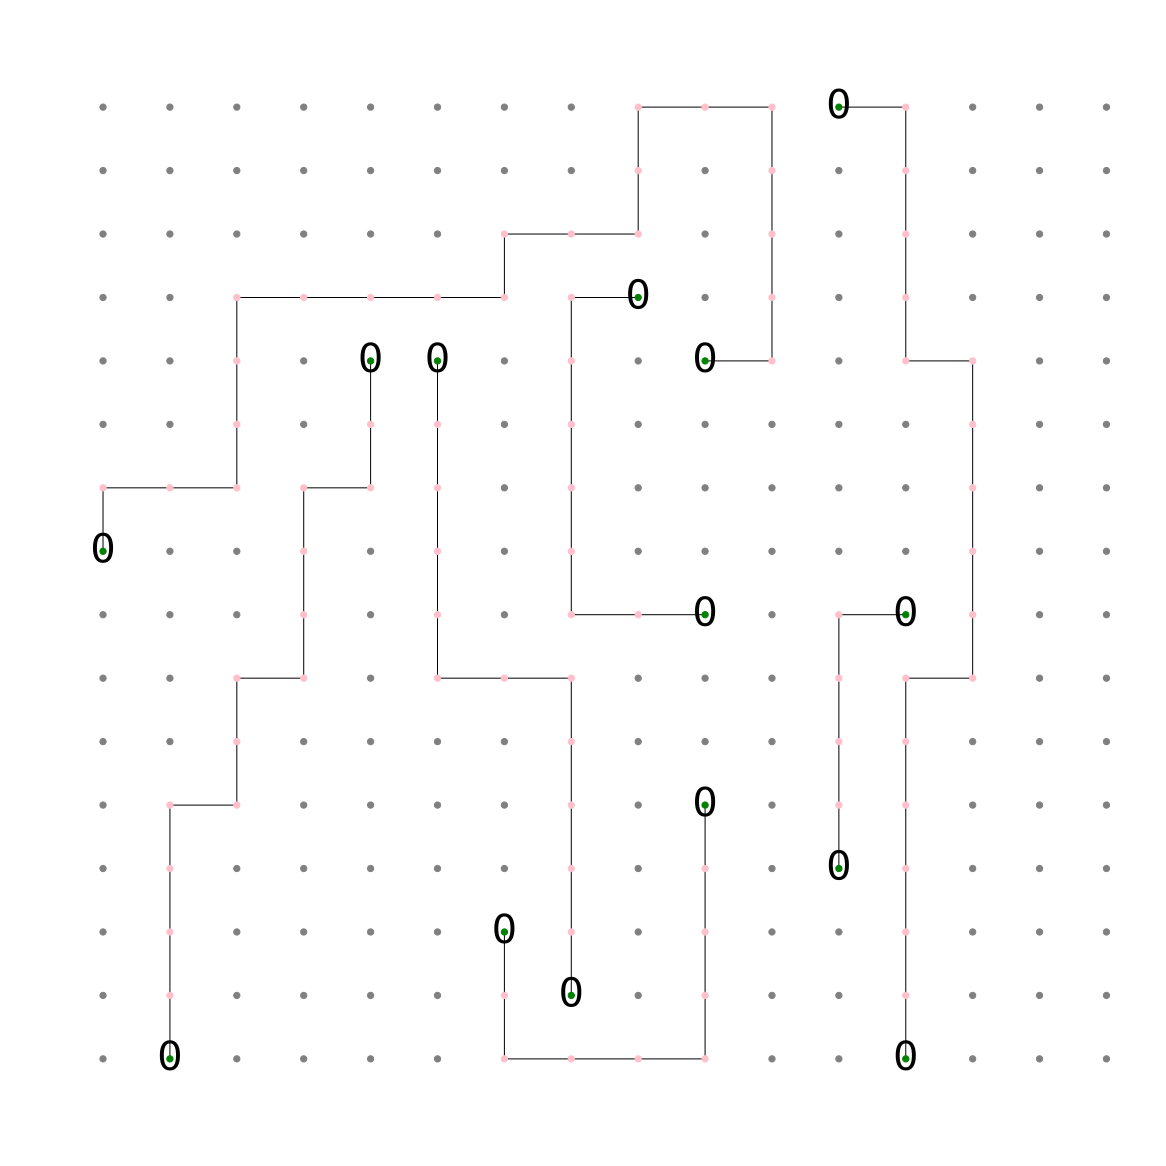

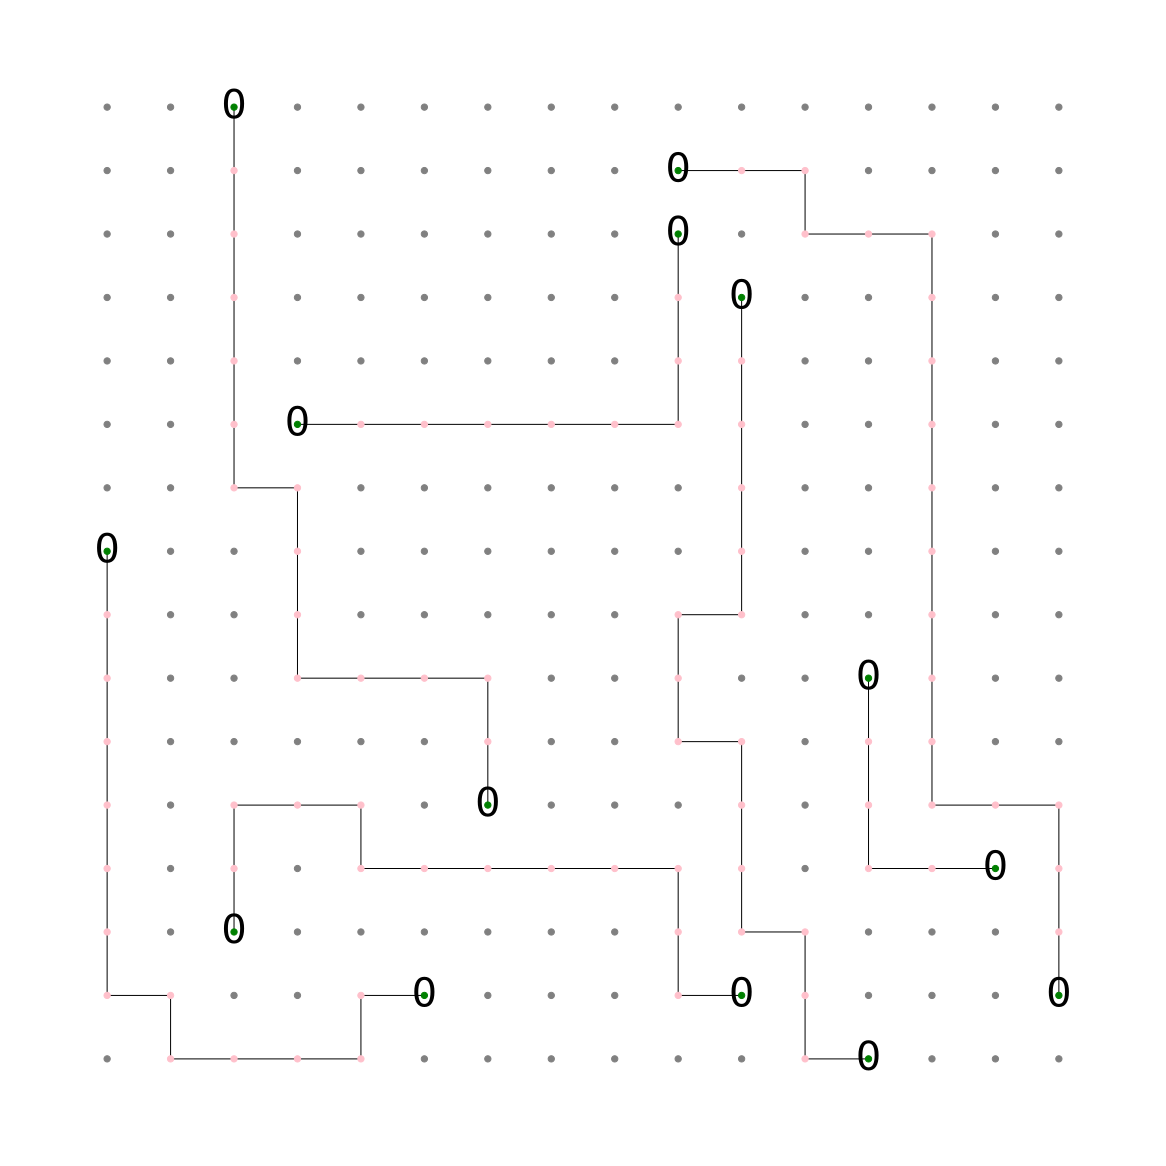

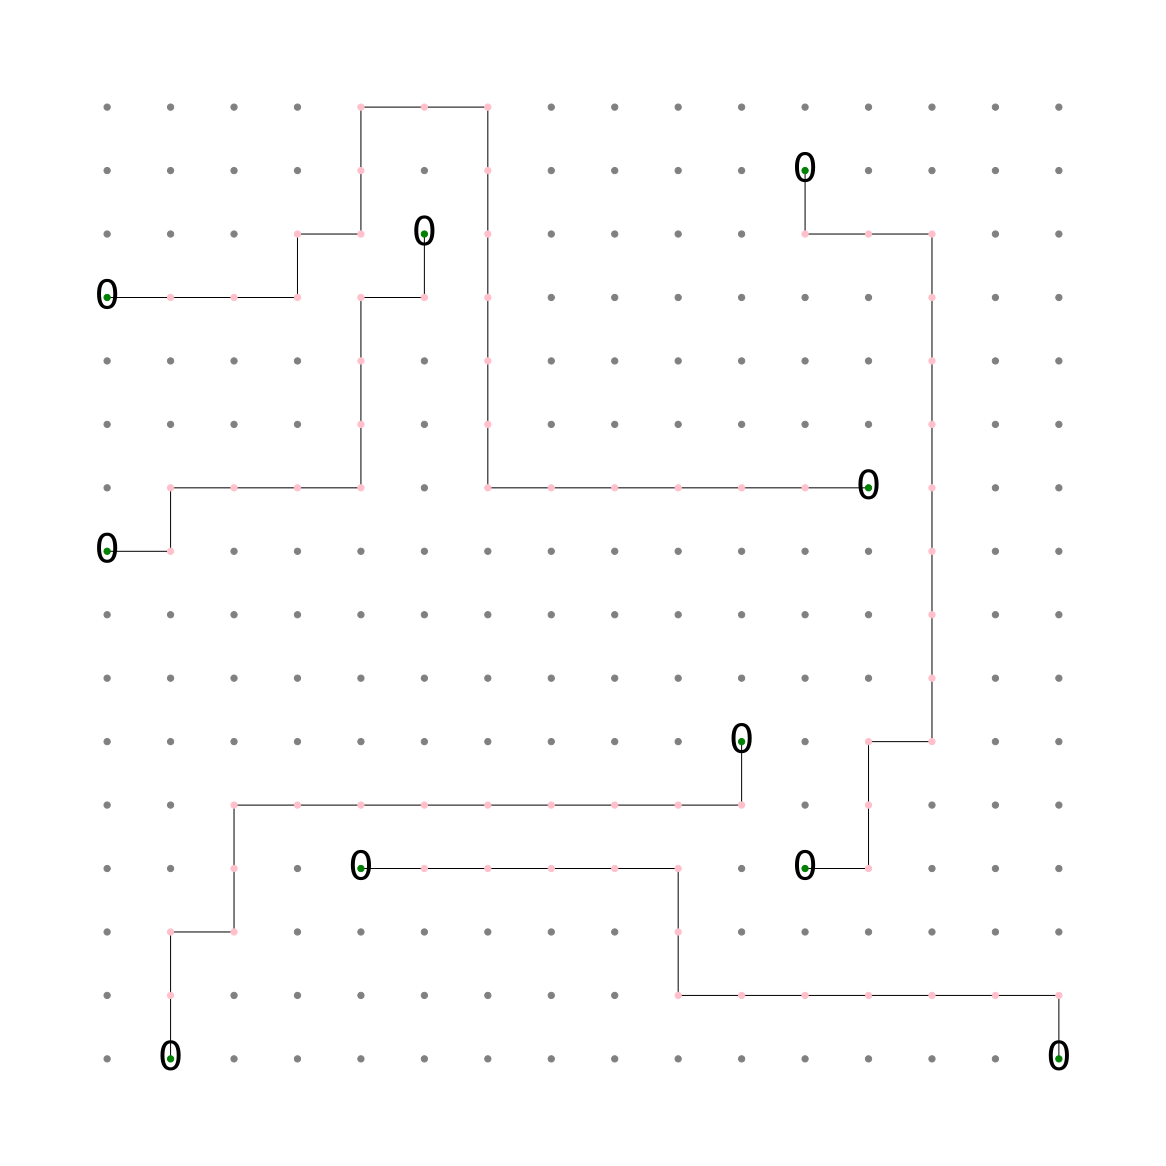

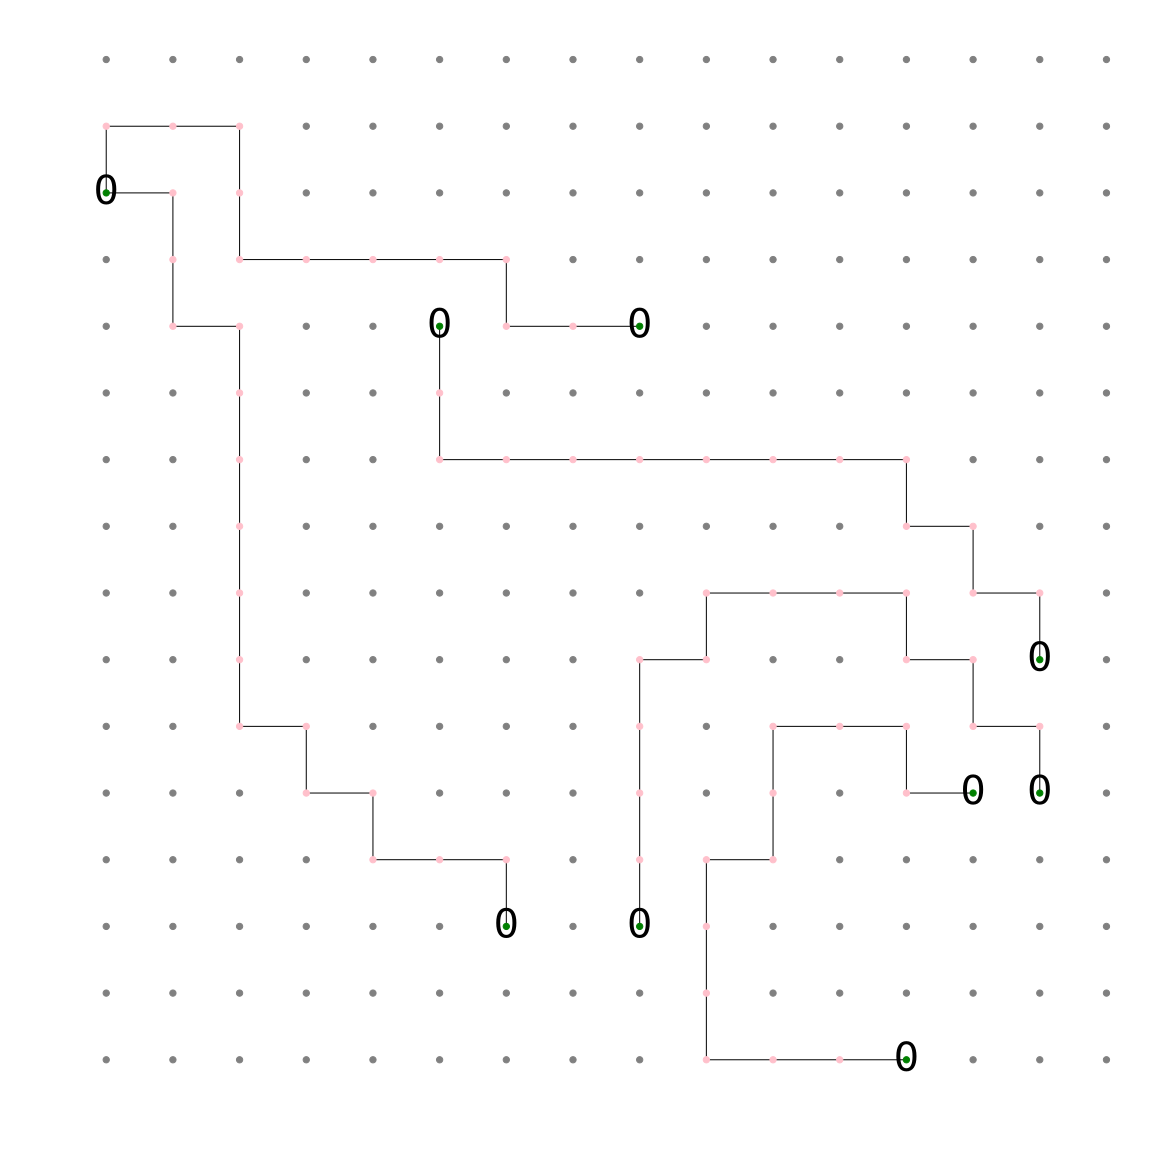

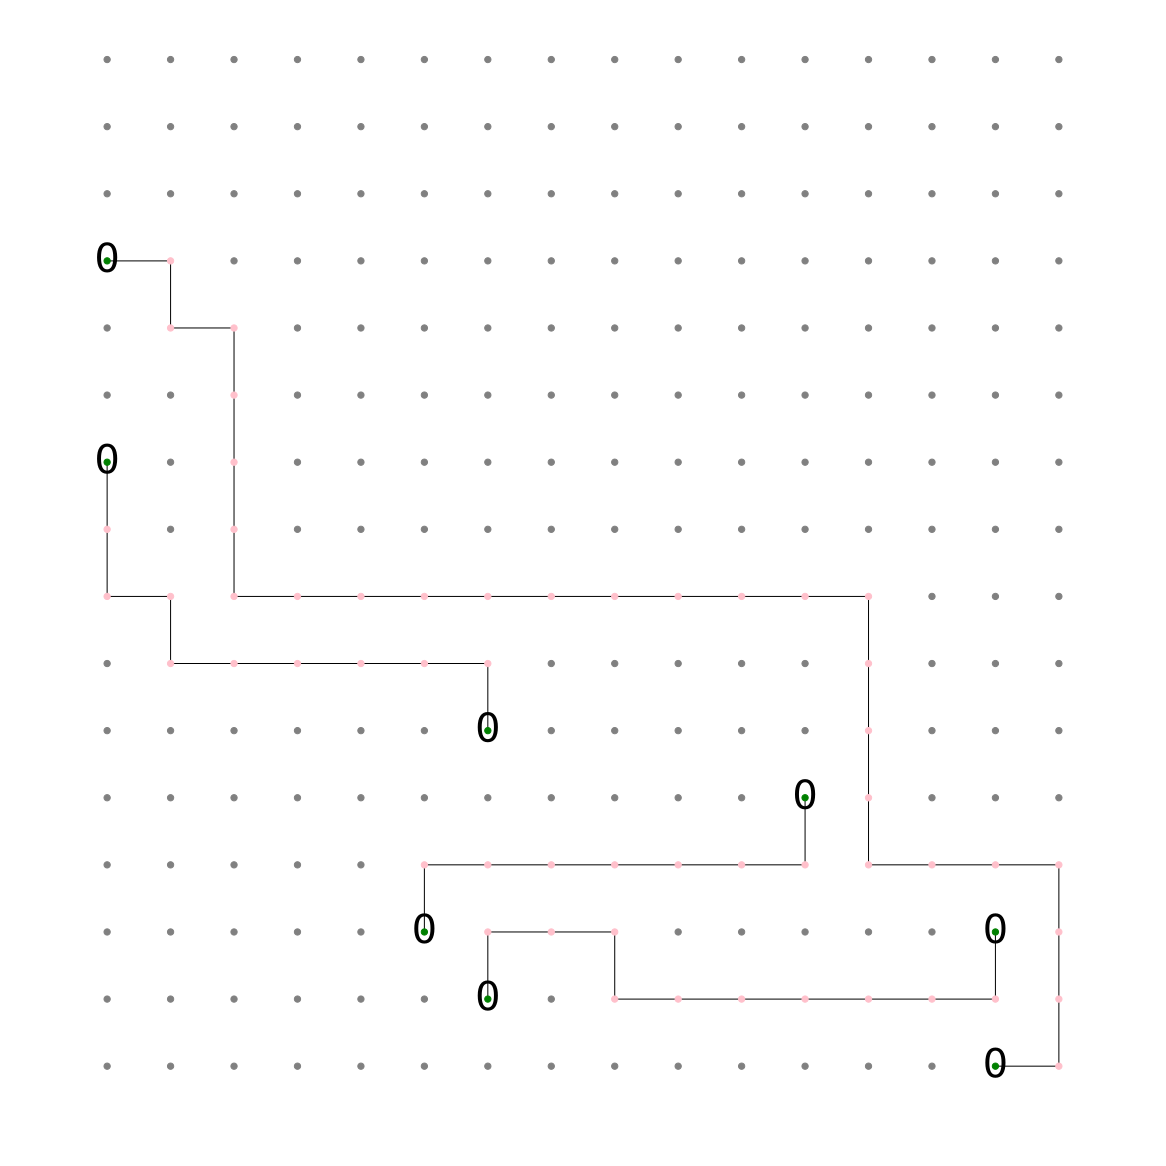

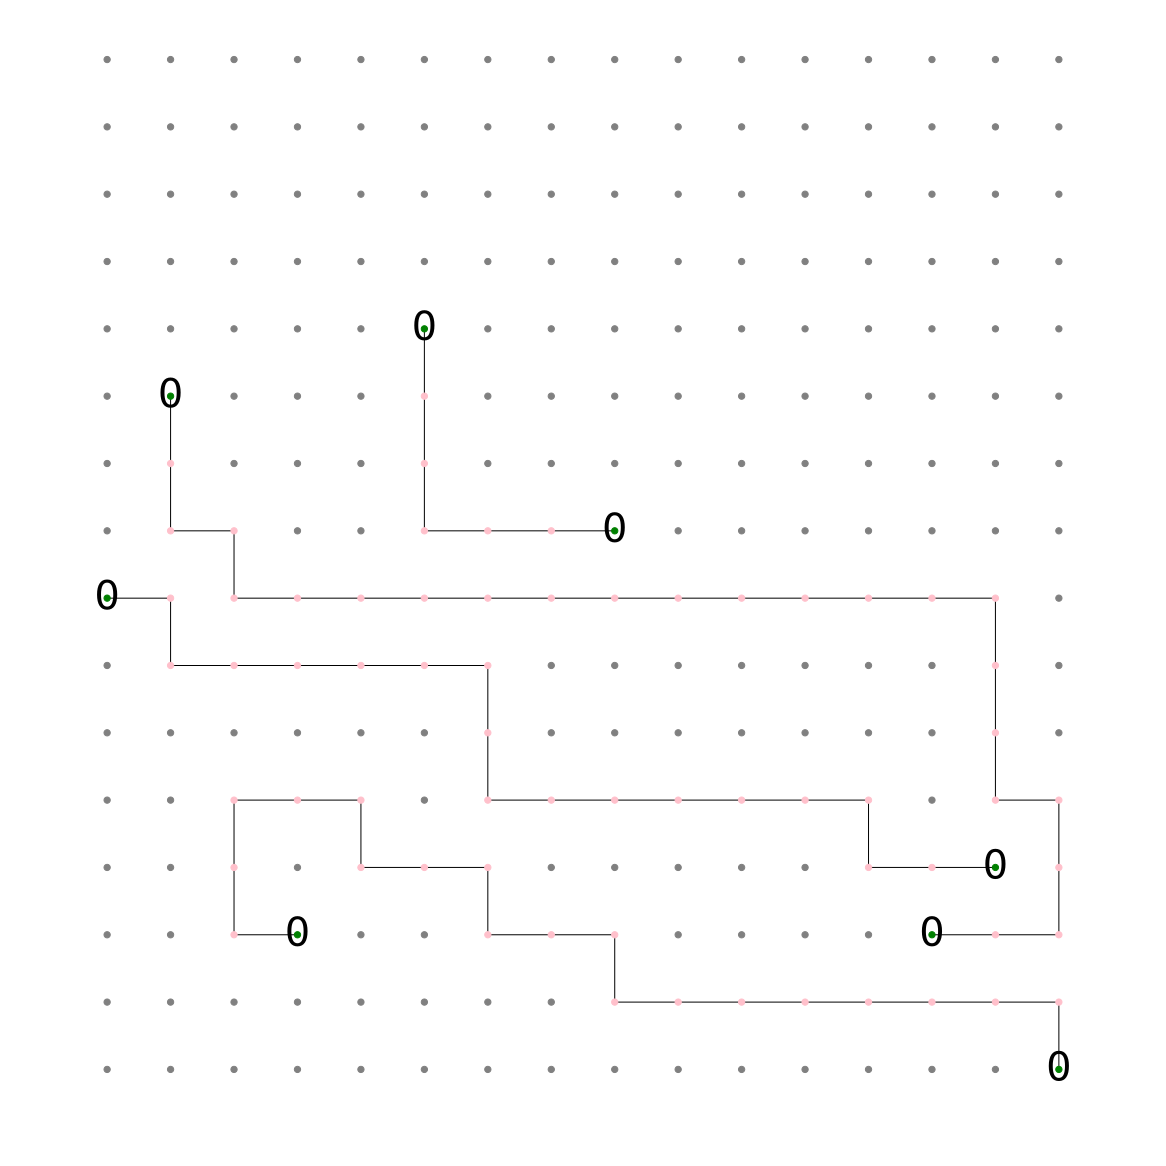

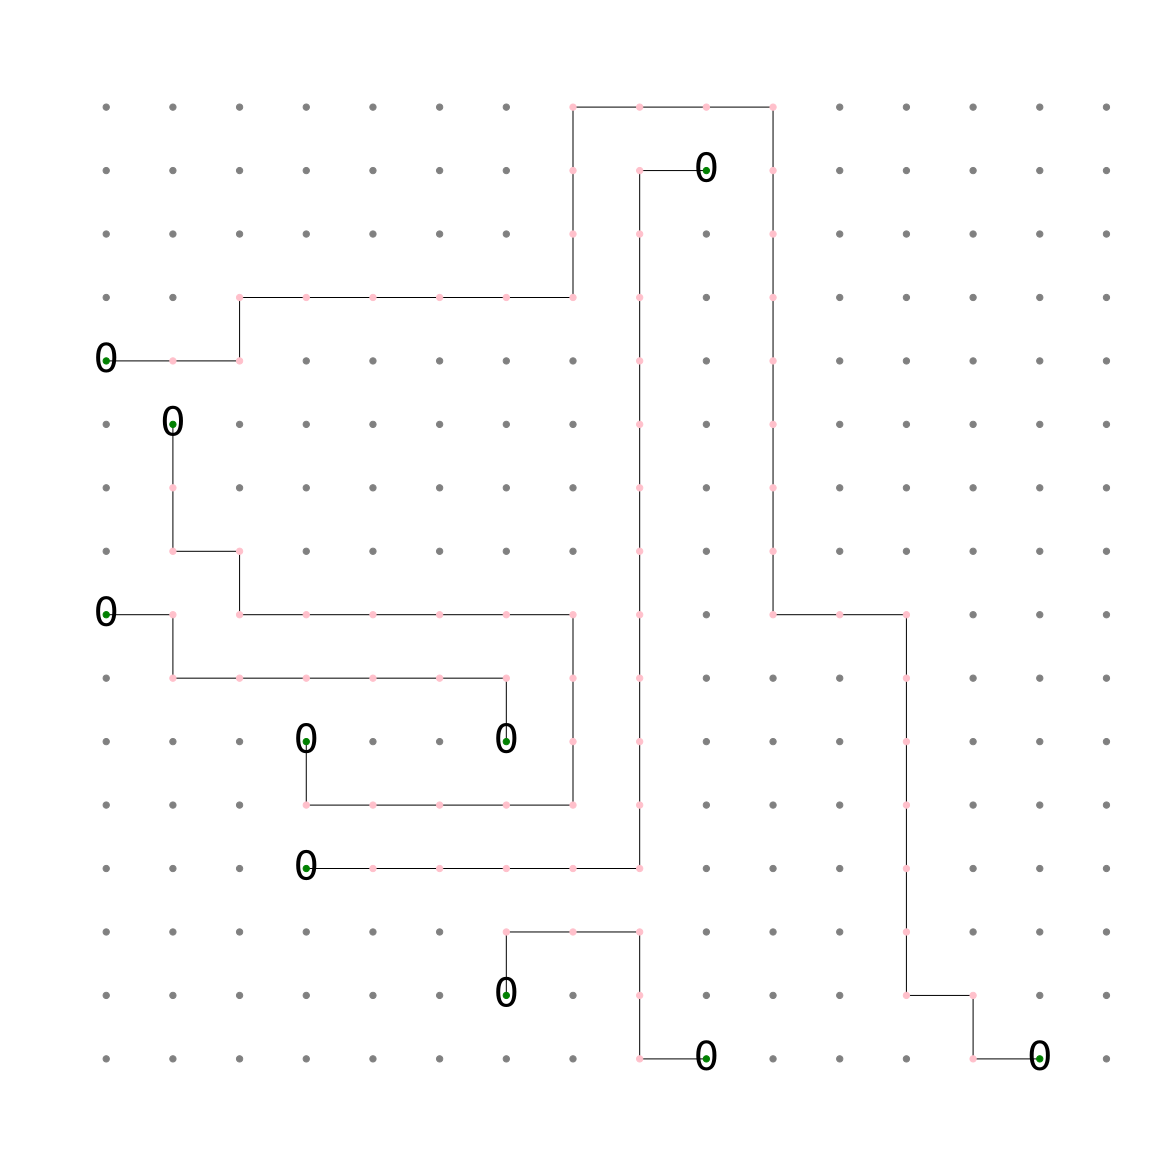

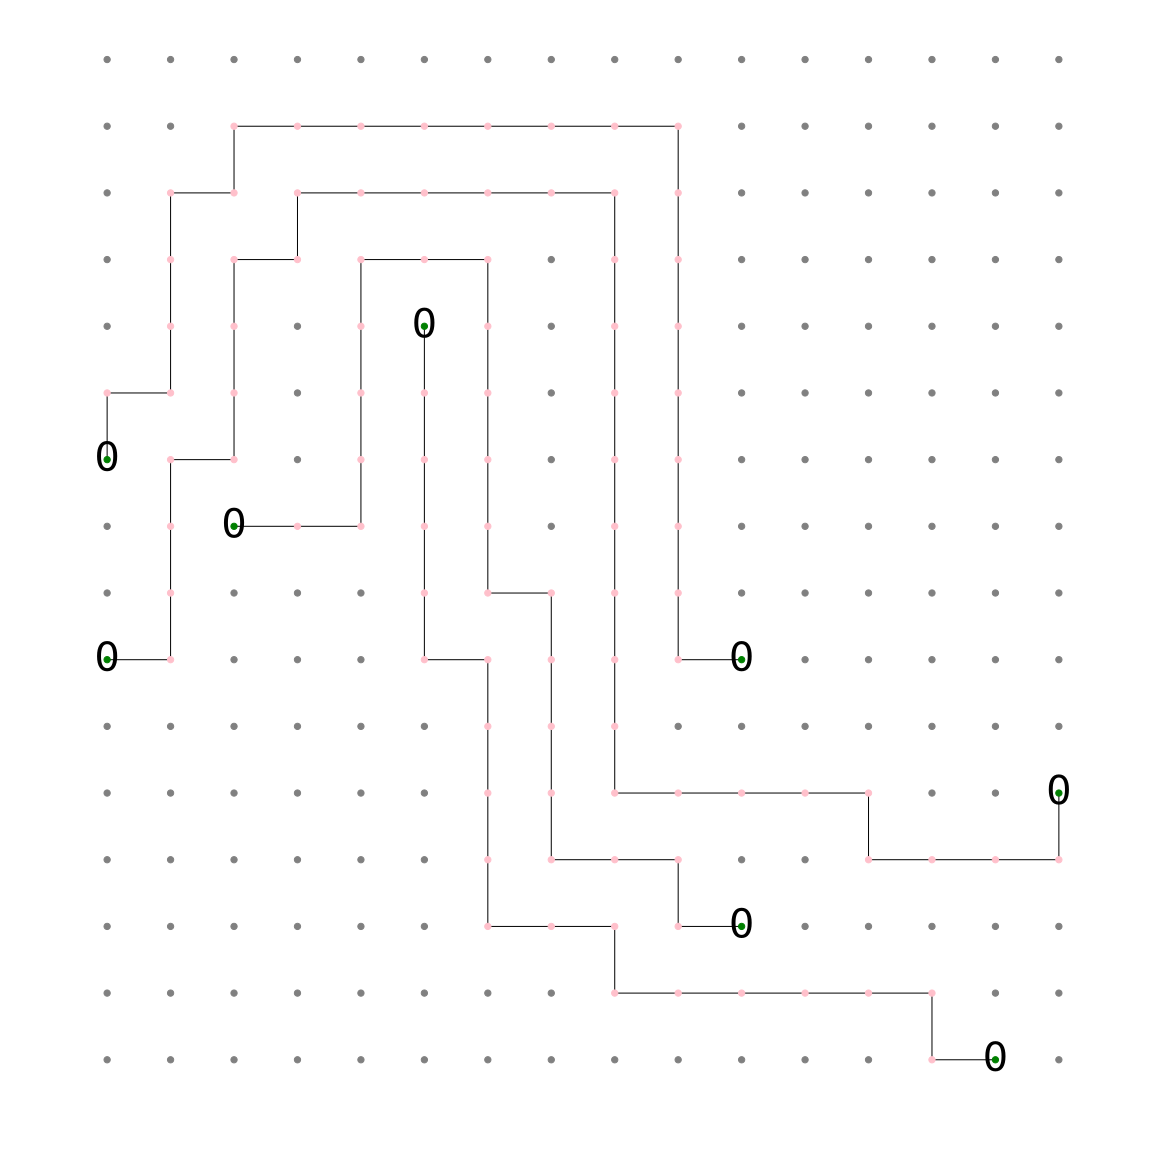

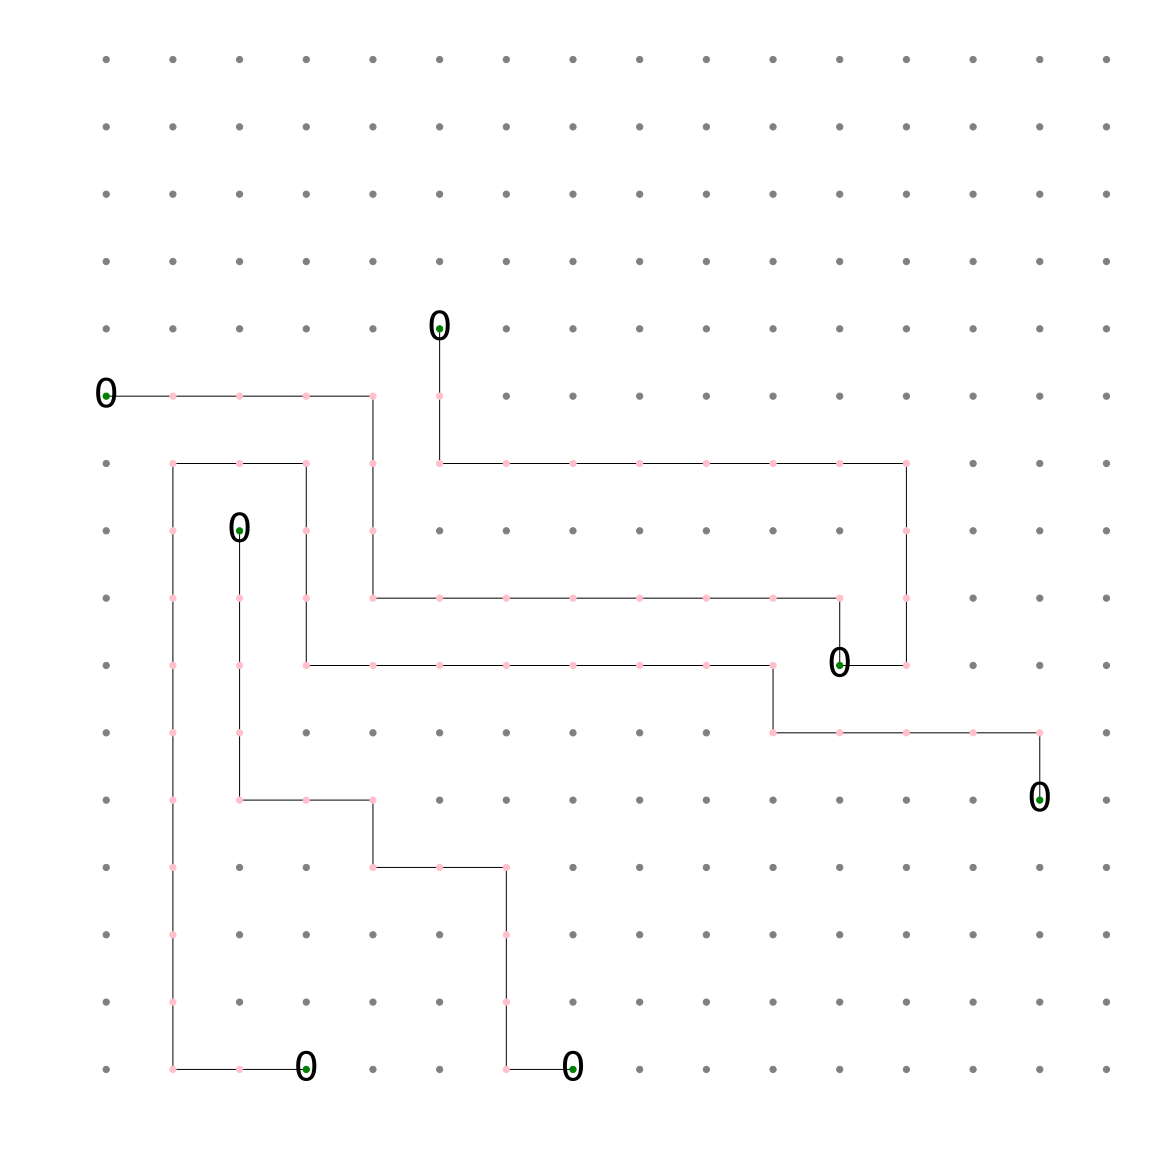

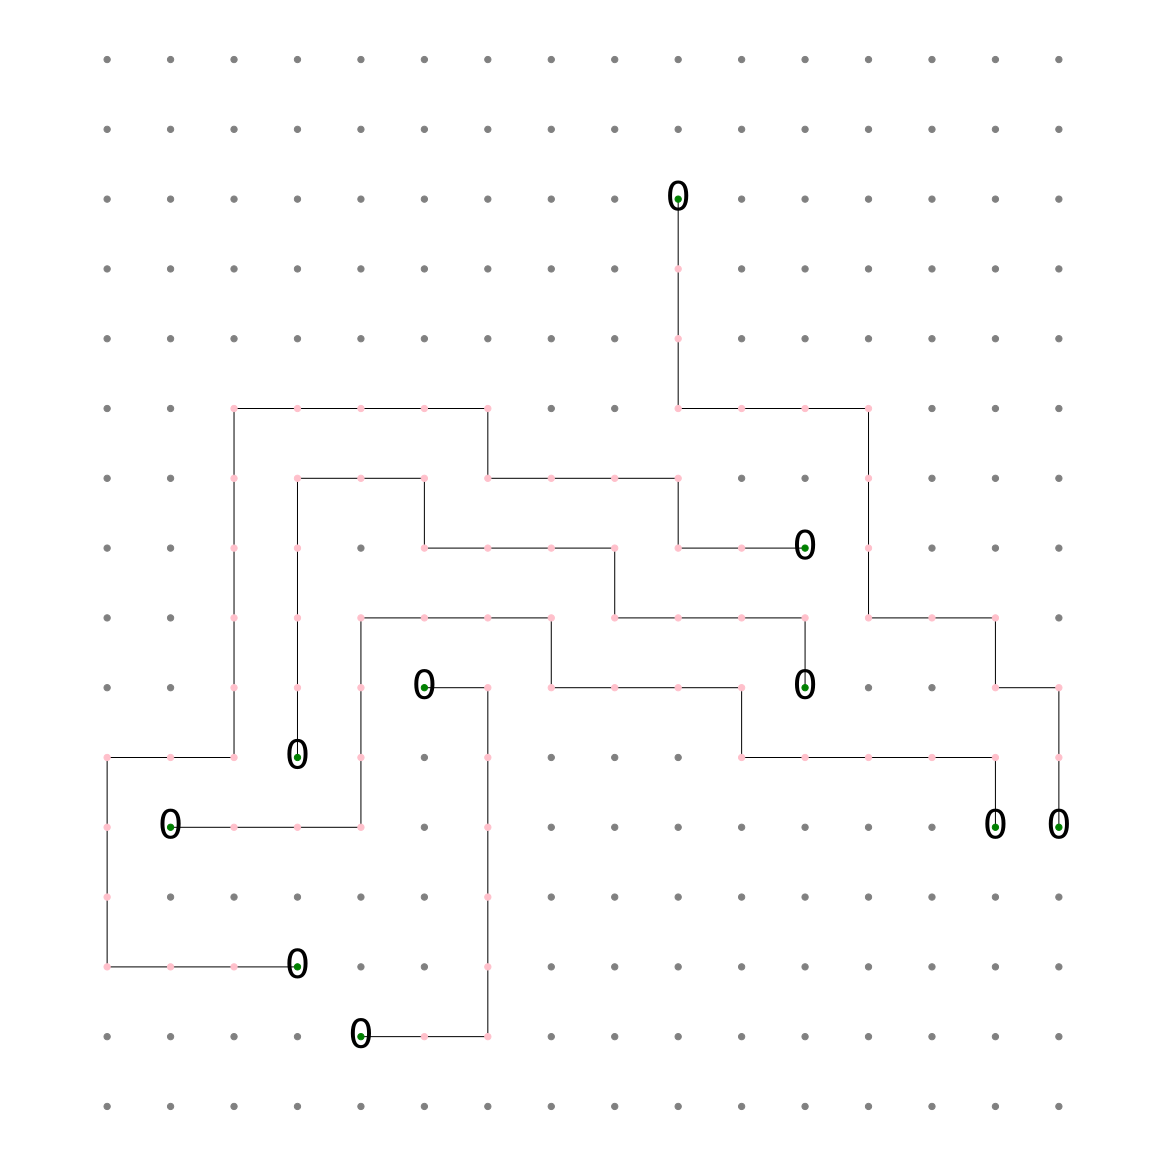

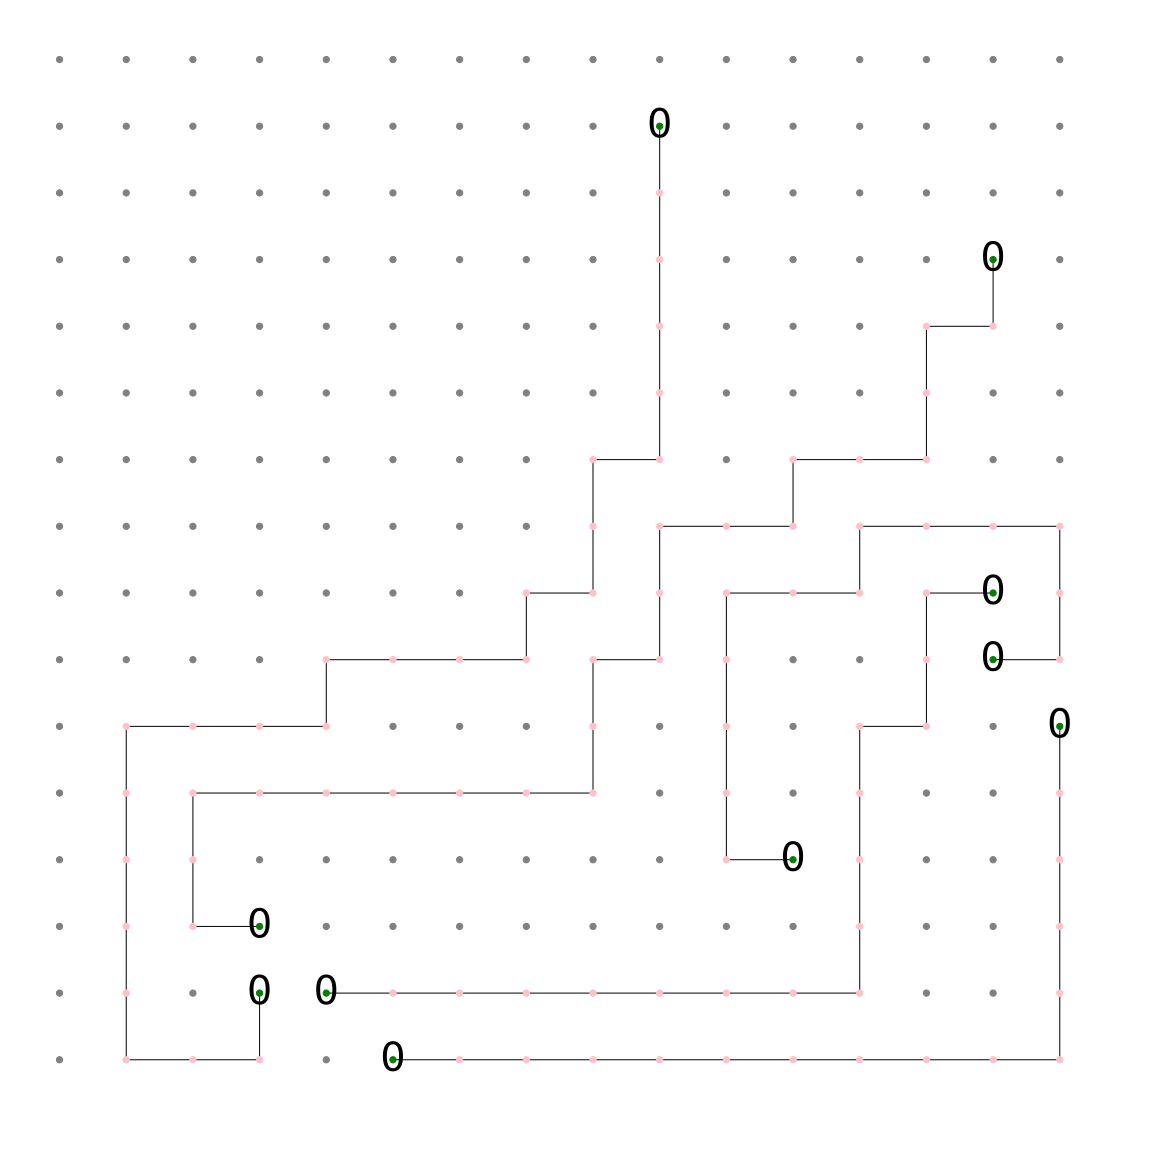

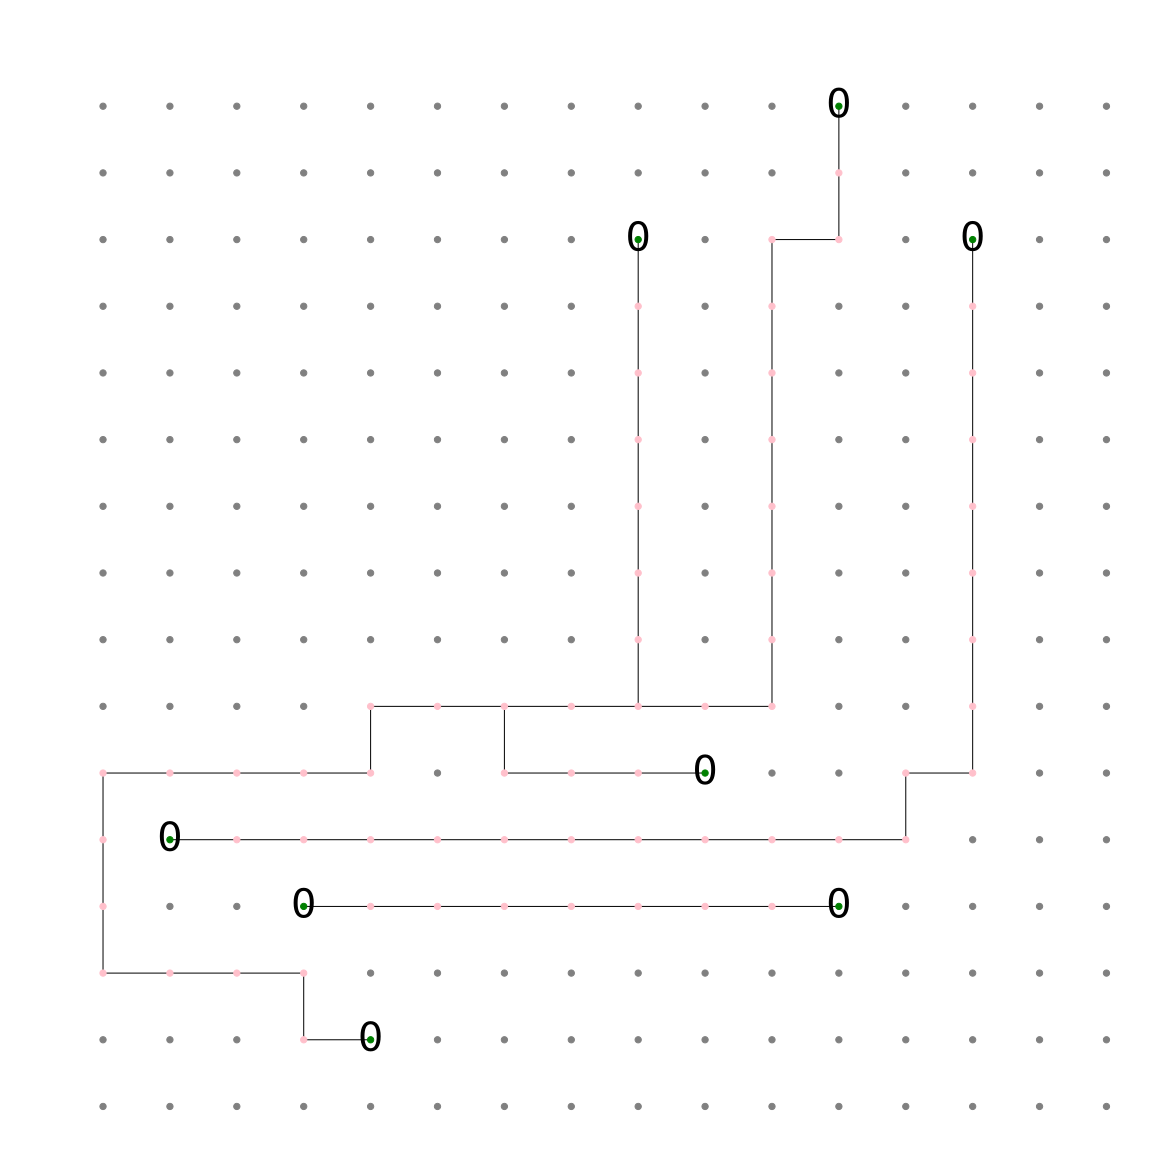

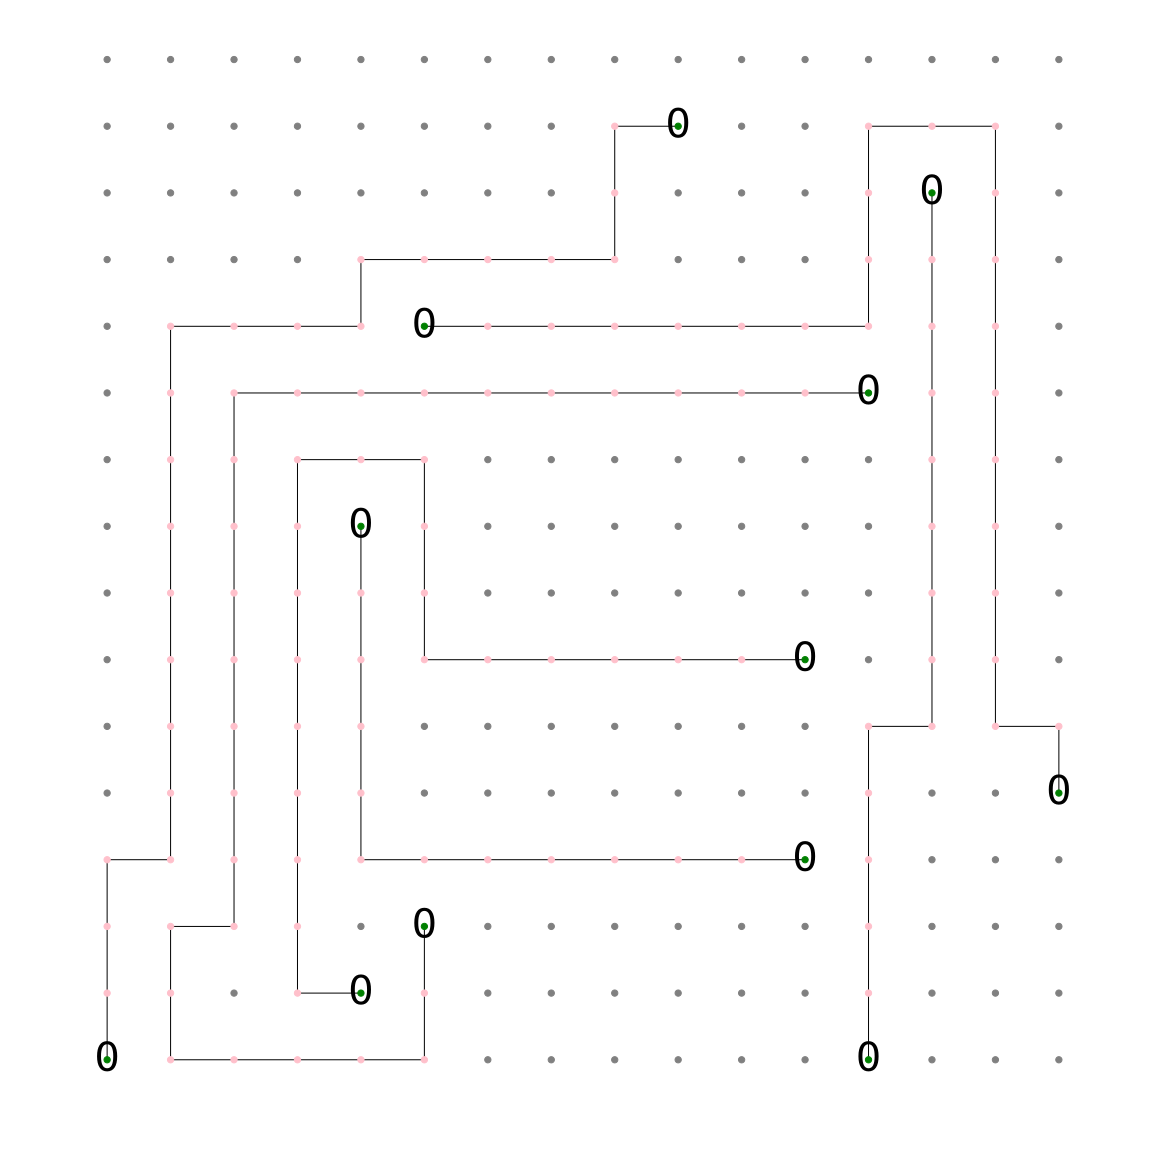

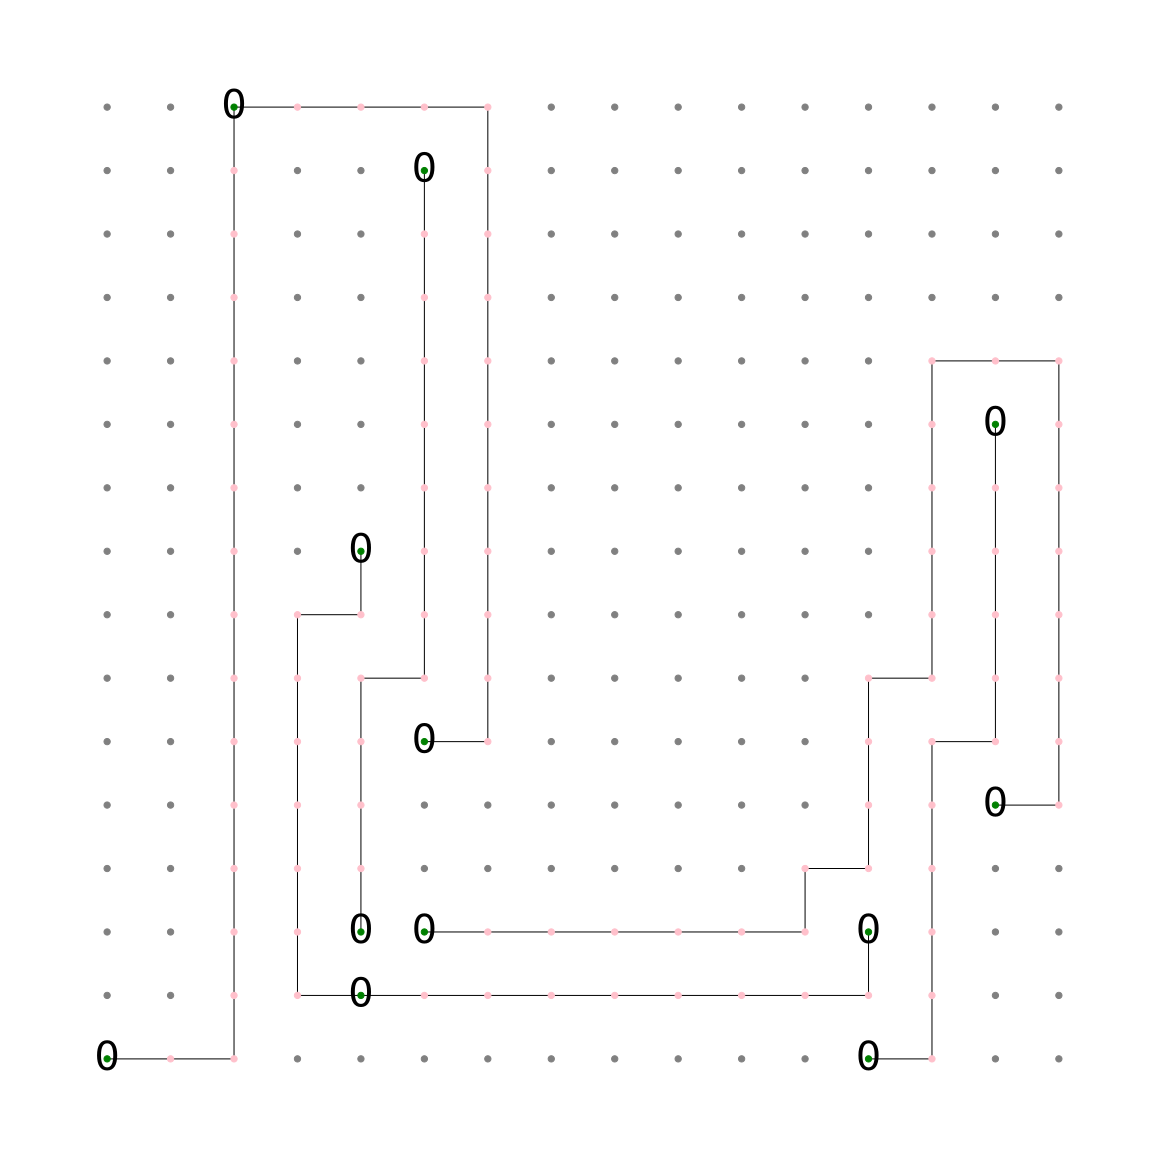

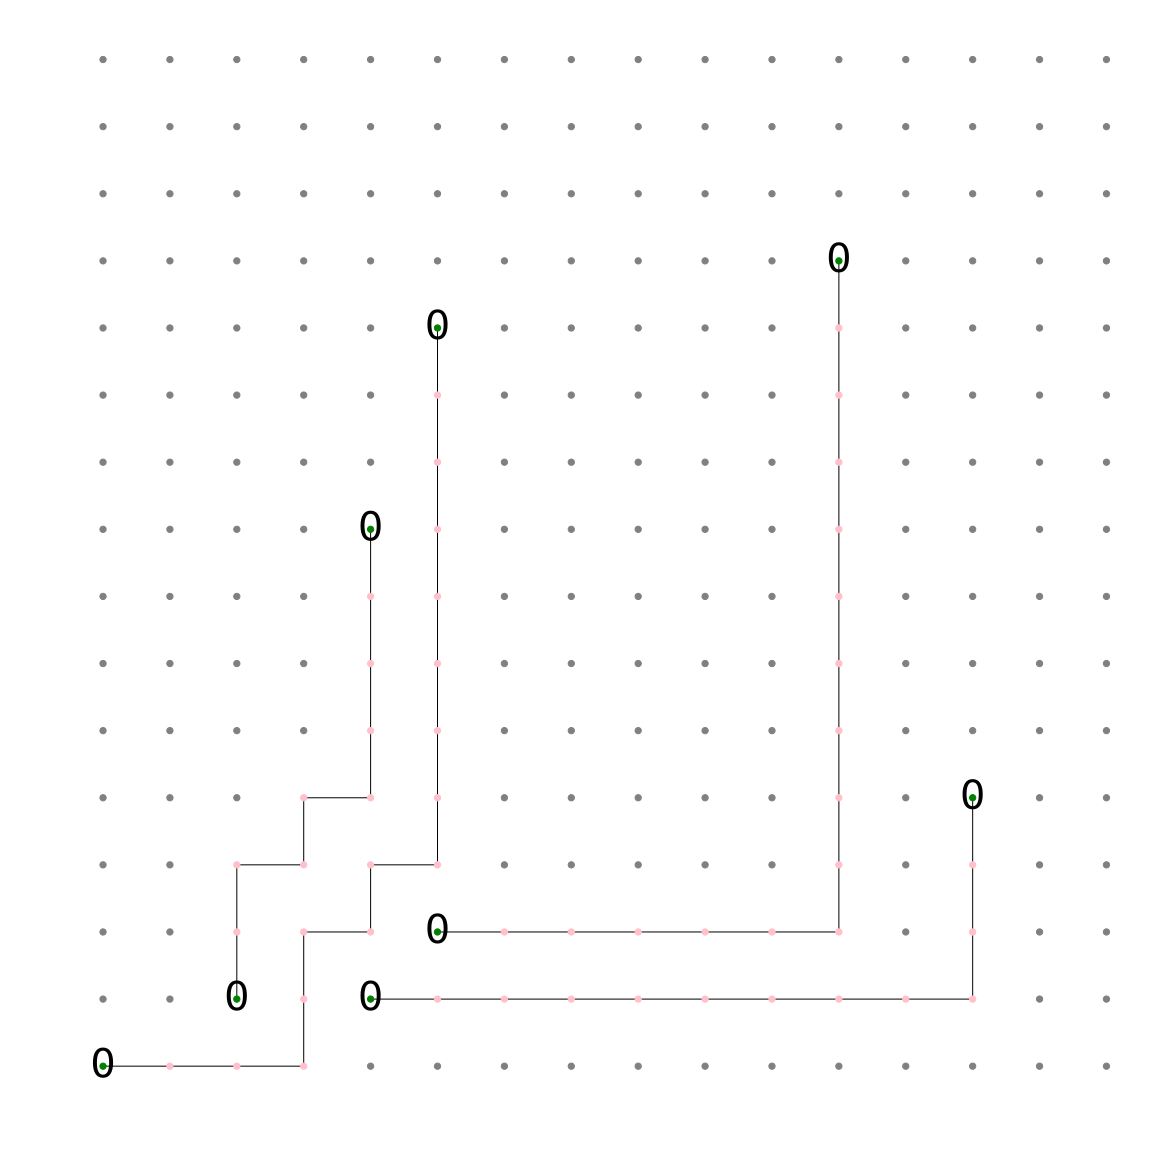

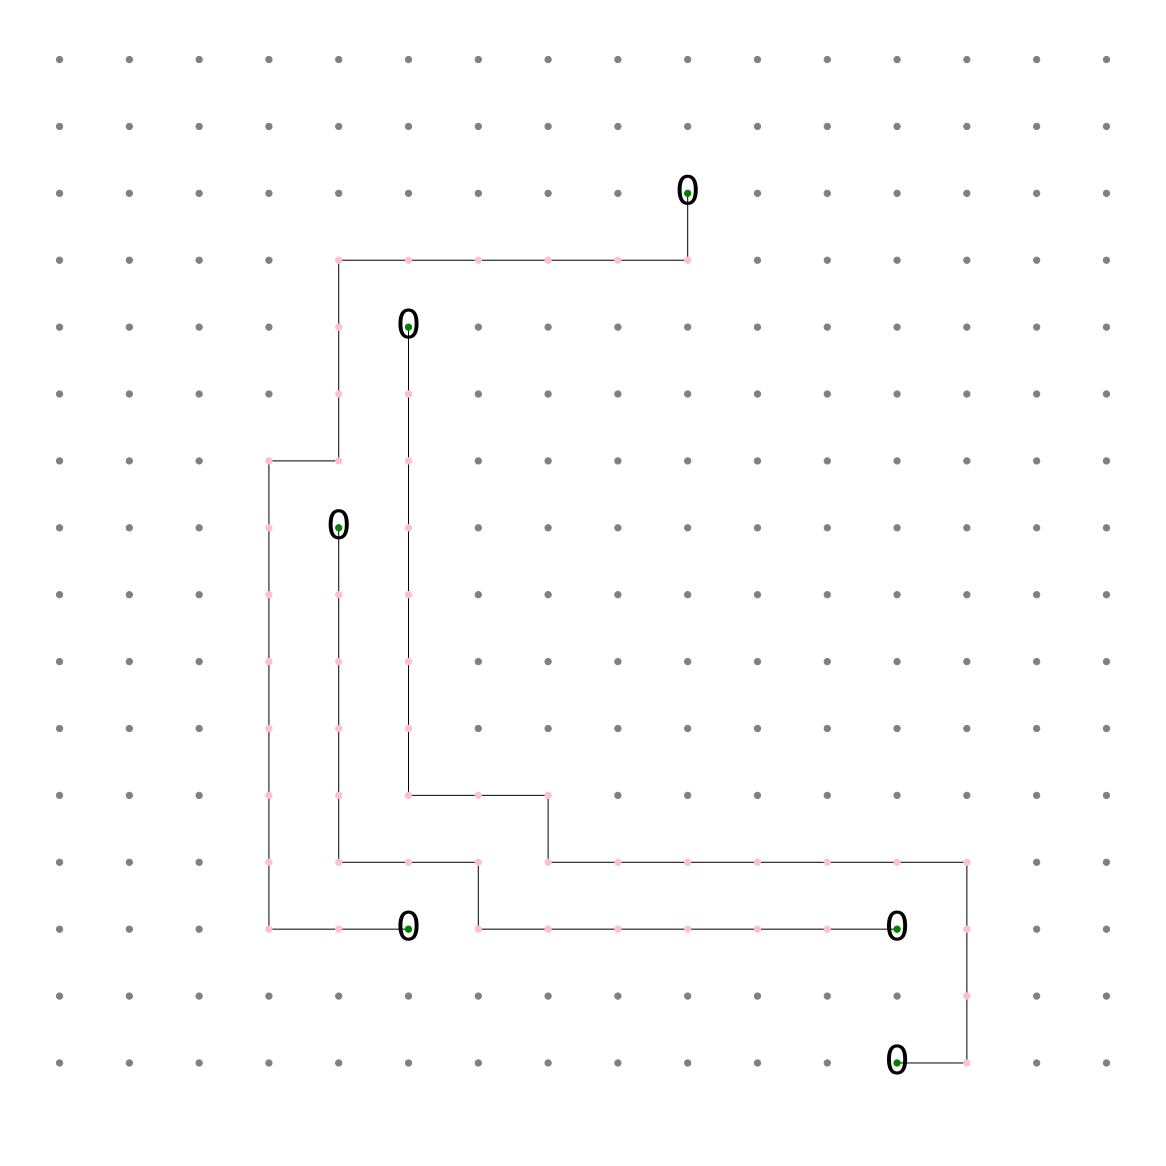

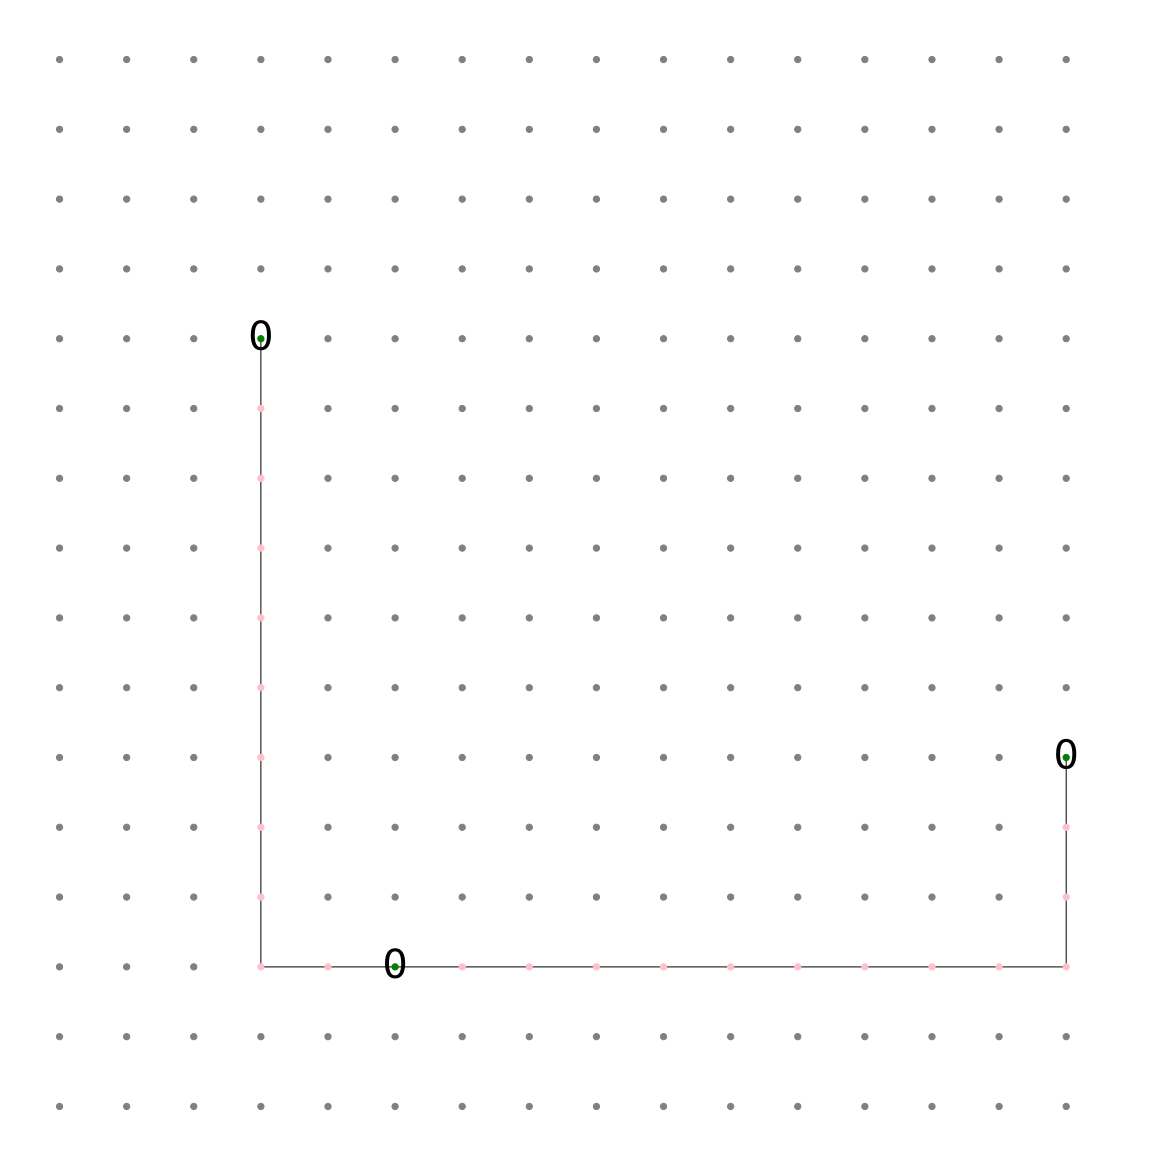

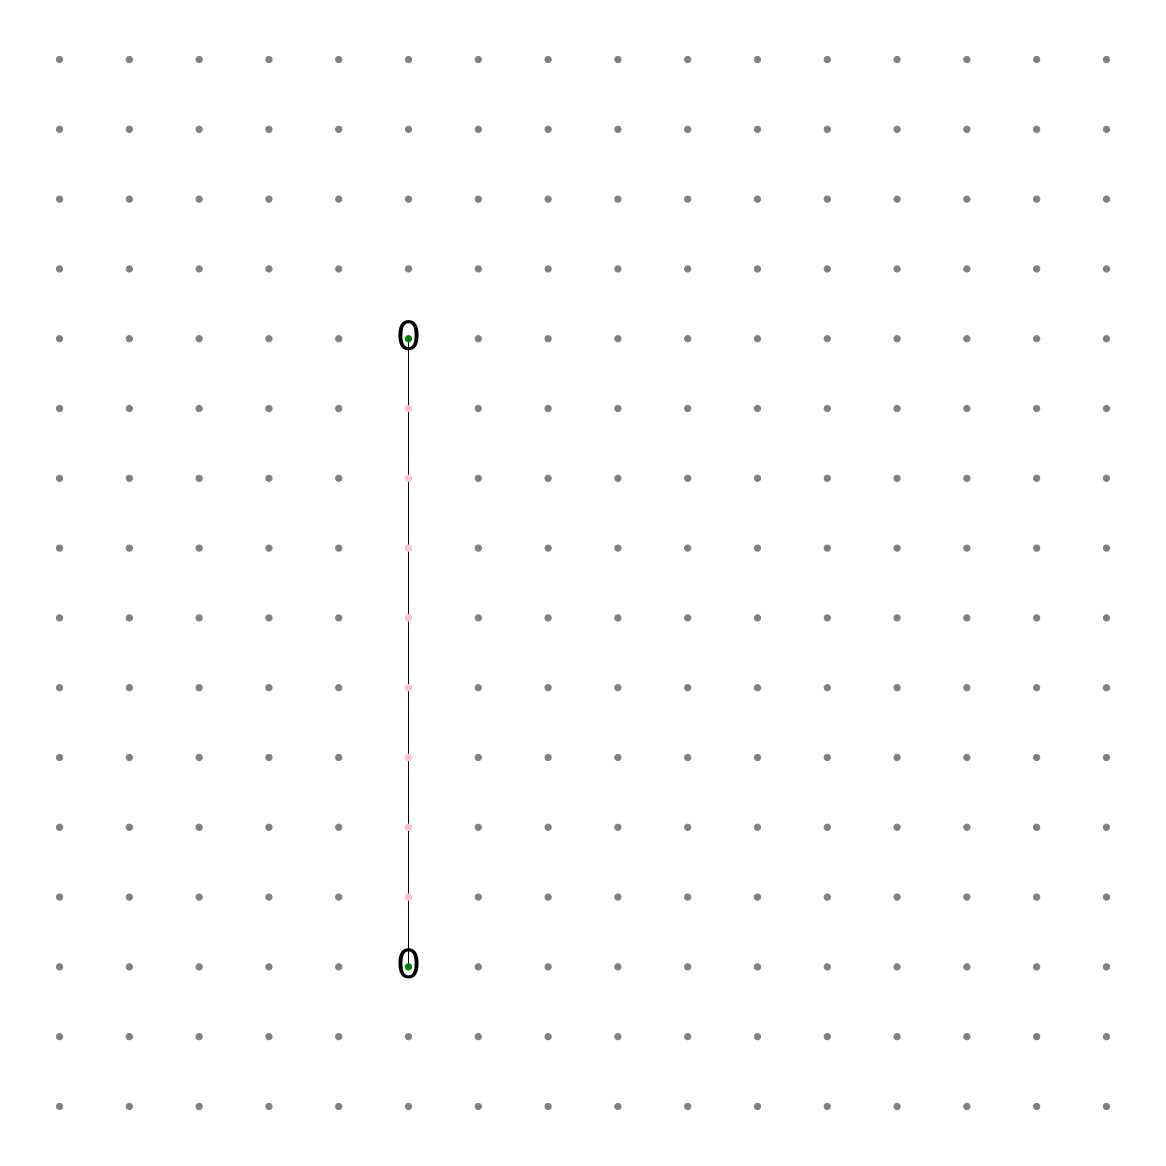

In [1]:
from Partition import *
from Fusion import *
from Graph_State import *
from Compact_Graph import *
from Validate import *
from Construct_Test_Circuit import *
from Add_Round import *

NQubit = 16
Depth = 400
MaxDegree = 3

def to_undirected(gs):
    undirected_graph = nx.Graph()
    for nnode in gs.nodes():
        undirected_graph.add_node(nnode)
        undirected_graph.nodes[nnode]['layer'] = gs.nodes[nnode]['layer']
    for edge in gs.edges():
        if edge not in undirected_graph.edges():
            undirected_graph.add_edge(edge[0], edge[1])
    return undirected_graph

def main():
    # gates_list, qubits = generate_circuit(NQubit, Depth)
    gates_list, qubits = construct_qaoa(NQubit, 0.5)
    gs, input_nodes, colors = generate_graph_state(gates_list, qubits)
    # for gnode in gs.nodes():
    #     gs.nodes[gnode]['layer'] = 0
    gs = partition(gs, input_nodes)
    undirected_graph = to_undirected(gs)
    fgraph, added_nodes = fusion_graph(undirected_graph, MaxDegree)
    fgraph = add_round(fgraph, 1)
    net_list = compact_graph(fgraph)
    fusions = 0
    for net in net_list:
        fusions += len(list(net.edges()))
    print("fusion:", fusions)
    fgraph = validate(net_list, fgraph)   
    return

if __name__ == '__main__':
    main()